# **3D Head and Neck Tumor Segmentation (HNTS) using 3D Swin UNETR**

**Import necessary libraries**

In [27]:
# Standard Library Imports
import os
import shutil
import tempfile
import urllib.request
import zipfile

# Data Processing & Visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from tqdm import tqdm

# PyTorch & Deep Learning
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Medical Imaging Libraries
import nibabel as nib

# MONAI (Medical Open Network for AI)
from monai.config import print_config
from monai.data import (
    CacheDataset,
    load_decathlon_datalist,
    decollate_batch,
    set_track_meta,
    ThreadDataLoader,
)
from monai.transforms import (
    AsDiscrete,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandFlipd,
    RandCropByPosNegLabeld,
    RandShiftIntensityd,
    ScaleIntensityRanged,
    Spacingd,
    RandRotate90d,
    EnsureTyped,
)
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.metrics import DiceMetric
from monai.networks.nets import UNet
from monai.networks.layers import Norm

# Suppress all warnings
import warnings
warnings.filterwarnings("ignore")

**Seed for Reproducibility**

In [28]:
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    import random
    random.seed(seed)
    torch.backends.cudnn.deterministic = True

# Apply seeding
set_seed(0)

**Paramters**

In [29]:
# Paths
DATA_PATH = '/cluster/projects/vc/data/mic/open/HNTS-MRG'
ZIP_FILE = os.path.join(DATA_PATH, 'HNTSMRG24_train.zip')
EXTRACTED_PATH = '/cluster/home/bjorneme/projects/tdt17_mini_project/TDT17_mini_project/Data'
TRAIN_DIR = os.path.join(EXTRACTED_PATH, 'HNTSMRG24_train')

# Training Parameters
BATCH_SIZE_TRAIN = 2               # Number of samples per training batch
NUM_WORKERS = 4                    # Number of subprocesses for data loading
NUM_EPOCHS = 250                    # Total number of training epochs
LEARNING_RATE = 1e-4               # Initial learning rate for optimizer
WEIGHT_DECAY = 1e-5                # Weight decay for optimizer
NUM_CLASSES = 3                    # Number of output classes (Background, GTVp, GTVn)
NUM_SAMPLES = 4                    # Number of samples
ACCUMULATION_STEPS = 1             # Gradient accumulation steps. Used for simulate larger batch

# Learning Rate Scheduler Parameters
SCHEDULER_FACTOR = 0.5             # Factor used to reduce learning rate
SCHEDULER_PATIENCE = 50             # Epochs without improvement before changing learning rate
SCHEDULER_MIN_LR = 1e-6            # Lowest possible learning rate

# Device Configuration
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.backends.cudnn.benchmark = True

# **Step 1: Load Data**

In [30]:
def extract_data(zip_file, extract_path):
    """
    Extracts preRT files from the dataset zip.
    """

    os.makedirs(extract_path, exist_ok=True)
    with zipfile.ZipFile(zip_file, 'r') as zip_ref:
        preRT_files = [f for f in zip_ref.namelist() if '/preRT/' in f]
        zip_ref.extractall(path=extract_path, members=preRT_files)
    print(f"Data extracted to {extract_path}")

# Extract data
extract_data(ZIP_FILE, EXTRACTED_PATH)

Data extracted to /cluster/home/bjorneme/projects/tdt17_mini_project/TDT17_mini_project/Data


# **Step 2: Exploratory Data Analysis**

**Count number of patients**

In [31]:
# Path to the training data
train_dir = os.path.join(EXTRACTED_PATH, 'HNTSMRG24_train')

# List all patient folders
patient_folders = os.listdir(TRAIN_DIR)
print(f"Total patients extracted: {len(patient_folders)}")

Total patients extracted: 150


**Prepare EDA**

In [32]:
# Initialize lists to store image information
dimensions = []
voxel_sizes = []
intensities = []
mask_voxel_counts = []

for patient_id in patient_folders:

    mri_path = os.path.join(train_dir, patient_id, 'preRT', f'{patient_id}_preRT_T2.nii.gz')
    mask_path = os.path.join(train_dir, patient_id, 'preRT', f'{patient_id}_preRT_mask.nii.gz')
    
    # Load MRI and mask
    mri_img = nib.load(mri_path)
    mask_img = nib.load(mask_path)
    
    # Get data arrays
    mri_data = mri_img.get_fdata()
    mask_data = mask_img.get_fdata()
    
    # Collect image dimensions and voxel sizes
    dimensions.append(mri_data.shape)
    voxel_sizes.append(mri_img.header.get_zooms())
    
    # Collect intensity statistics
    intensities.append({
        'mean': np.mean(mri_data),
        'std': np.std(mri_data),
        'min': np.min(mri_data),
        'max': np.max(mri_data),
    })
    
    # Count the number of voxels in each class
    unique, counts = np.unique(mask_data, return_counts=True)
    mask_voxel_counts.append(dict(zip(unique.astype(int), counts)))

**EDA: Image Dimensions**

In [33]:
# Convert dimensions to a NumPy array
dimensions_array = np.array(dimensions)

# Calculate min, max, and mean dimensions
min_dims = dimensions_array.min(axis=0)
max_dims = dimensions_array.max(axis=0)
mean_dims = dimensions_array.mean(axis=0)

# Create a DataFrame for the results
data = {
    "Statistic": ["Minimum", "Maximum", "Mean (rounded)"],
    "Width": [min_dims[0], max_dims[0], mean_dims[0]],
    "Height": [min_dims[1], max_dims[1], mean_dims[1]],
    "Depth": [min_dims[2], max_dims[2], mean_dims[2]]
}

# Display as dataframe
pd.DataFrame(data)

,Statistic,Width,Height,Depth
0,Minimum,512.000000,480.00,57.00
1,Maximum,768.000000,768.00,162.00
2,Mean (rounded),523.306667,522.88,84.04


**EDA: Tumor Sizes**

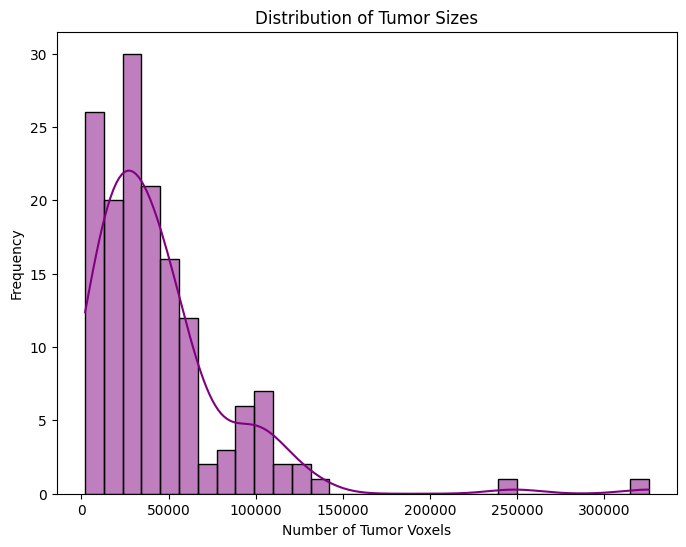

In [34]:
# Calculate tumor sizes
tumor_sizes = [counts.get(1, 0) + counts.get(2, 0) for counts in mask_voxel_counts]

# Plot distribution
plt.figure(figsize=(8, 6))
sns.histplot(tumor_sizes, bins=30, kde=True, color='purple')
plt.title('Distribution of Tumor Sizes')
plt.xlabel('Number of Tumor Voxels')
plt.ylabel('Frequency')
plt.show()

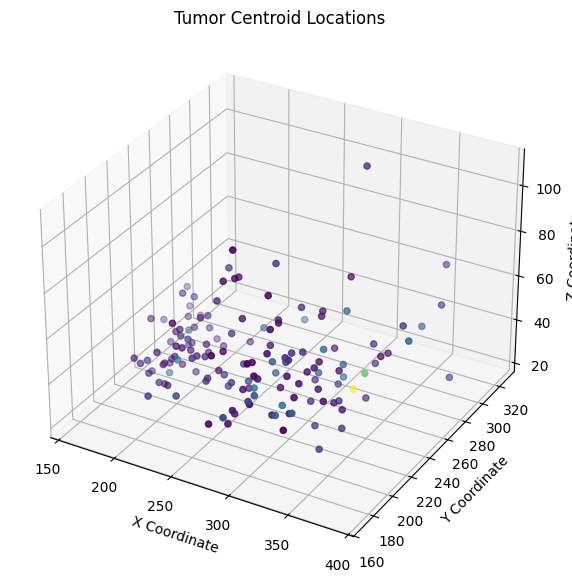

In [35]:
# Initialize lists
tumor_sizes = []
tumor_locations = []

for patient_id in patient_folders:
    mask_path = os.path.join(train_dir, patient_id, 'preRT', f'{patient_id}_preRT_mask.nii.gz')
    mask_img = nib.load(mask_path)
    mask_data = mask_img.get_fdata().astype(int)

    # Calculate tumor size (number of voxels in tumor classes)
    tumor_voxels = mask_data > 0
    size = np.sum(tumor_voxels)
    tumor_sizes.append(size)

    # Calculate tumor centroid
    coords = np.column_stack(np.where(mask_data > 0))
    if coords.size > 0:
        centroid = coords.mean(axis=0)
        tumor_locations.append(centroid)
    else:
        tumor_locations.append([np.nan, np.nan, np.nan])

# Convert to DataFrame
eda_df = pd.DataFrame({
    'Patient_ID': patient_folders,
    'Tumor_Size': tumor_sizes,
    'Centroid_X': [loc[0] for loc in tumor_locations],
    'Centroid_Y': [loc[1] for loc in tumor_locations],
    'Centroid_Z': [loc[2] for loc in tumor_locations],
})

# 3D Scatter plot of tumor centroids
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(eda_df['Centroid_X'], eda_df['Centroid_Y'], eda_df['Centroid_Z'], c=eda_df['Tumor_Size'])
ax.set_title('Tumor Centroid Locations')
ax.set_xlabel('X Coordinate')
ax.set_ylabel('Y Coordinate')
ax.set_zlabel('Z Coordinate')
plt.show()

**EDA: Understand class distribution (Background, GTVp, GTVn)**

In [36]:
# Aggregate mask voxel counts
class_counts = {}
for counts in mask_voxel_counts:
    for k, v in counts.items():
        class_counts[k] = class_counts.get(k, 0) + v

# Calculate total voxels
total_voxels = sum(class_counts.values())

# Calculate percentages
class_percentages = {int(k): (v / total_voxels) * 100 for k, v in class_counts.items()}

# Define class labels
class_labels = {
    0: 'Background',
    1: 'GTVp',
    2: 'GTVn'
}

# Create a DataFrame for class distribution
class_df = pd.DataFrame({
    'Class': [class_labels.get(cls, f'Class {cls}') for cls in class_percentages.keys()],
    'Percentage (%)': [round(pct, 4) for pct in class_percentages.values()]
})

# Display the DataFrame
class_df

,Class,Percentage (%)
0,Background,99.8107
1,GTVp,0.0862
2,GTVn,0.1031


**EDA: Plot samples to check quality and type of data**

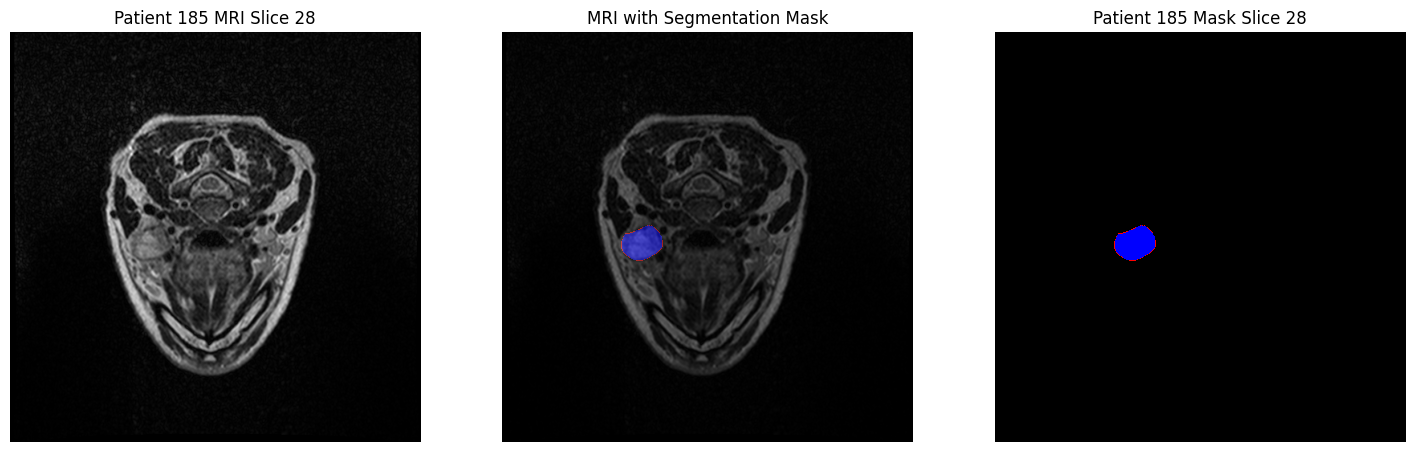

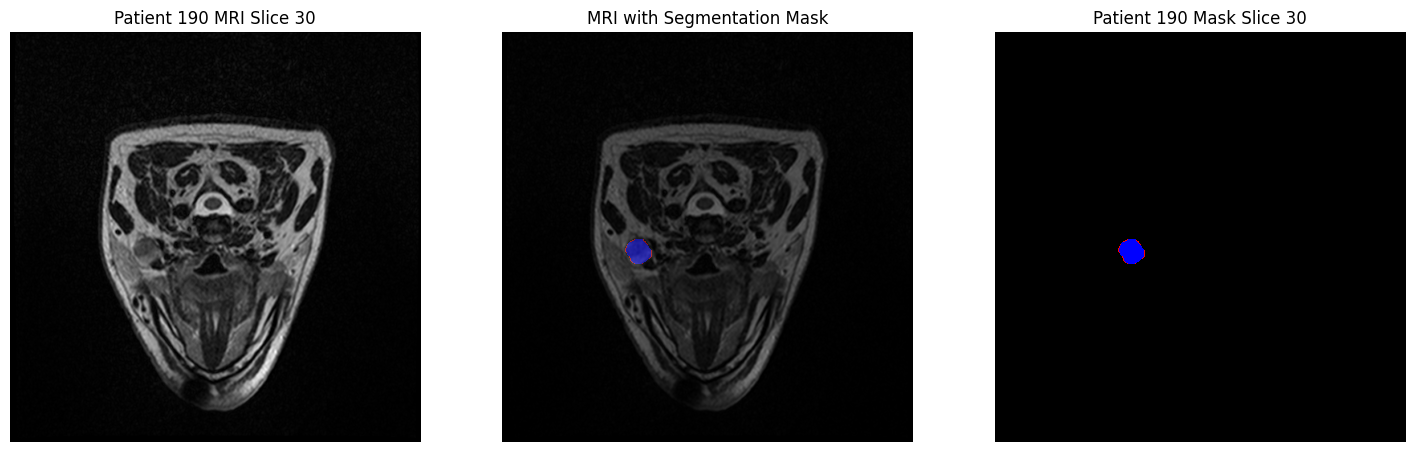

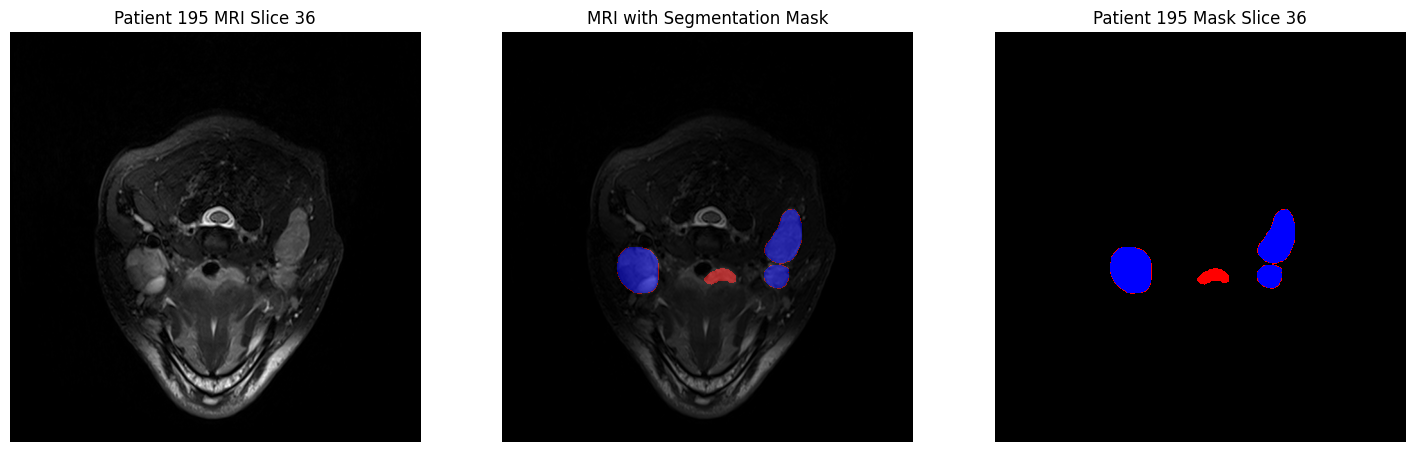

In [37]:
def plot_sample(patient_id, slice_index=None):
    # Define paths
    mri_path = os.path.join(train_dir, patient_id, 'preRT', f'{patient_id}_preRT_T2.nii.gz')
    mask_path = os.path.join(train_dir, patient_id, 'preRT', f'{patient_id}_preRT_mask.nii.gz')
    
    # Load data
    mri_data = nib.load(mri_path).get_fdata()
    mask_data = nib.load(mask_path).get_fdata().astype(int)
    
    # Select the middle slice
    slice_index = mri_data.shape[2] // 2
    mri_slice = mri_data[:, :, slice_index].T
    mask_slice = mask_data[:, :, slice_index].T
    
    # Define colormap for mask
    cmap = colors.ListedColormap(['black', 'red', 'blue'])
    norm = colors.BoundaryNorm([-0.5, 0.5, 1.5, 2.5], cmap.N)
    
    # Create subplots
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # 1. MRI Image
    axes[0].imshow(mri_slice, cmap='gray', origin='lower')
    axes[0].set_title(f'Patient {patient_id} MRI Slice {slice_index}')
    axes[0].axis('off')
    
    # 2. MRI with Mask Overlay
    axes[1].imshow(mri_slice, cmap='gray', origin='lower')
    axes[1].imshow(mask_slice, cmap=cmap, norm=norm, alpha=0.5, origin='lower')
    axes[1].set_title('MRI with Segmentation Mask')
    axes[1].axis('off')
    
    # 3. Mask Only
    im = axes[2].imshow(mask_slice, cmap=cmap, norm=norm, origin='lower')
    axes[2].set_title(f'Patient {patient_id} Mask Slice {slice_index}')
    axes[2].axis('off')

    plt.show()

# Plot samples from a few patients
patient_ids = ['185', '190', '195']
for pid in patient_ids:
    plot_sample(pid)

# **Step 3: Data Preprocessing**

**Create data dictionary**

In [38]:
def create_data_dicts(train_dir):
    """
    Creates data dictionaries for MONAI.
    """
    data_dicts = [
        {
            "image": os.path.join(train_dir, pid, 'preRT', f'{pid}_preRT_T2.nii.gz'),
            "label": os.path.join(train_dir, pid, 'preRT', f'{pid}_preRT_mask.nii.gz'),
        }
        for pid in patient_folders
    ]
    return data_dicts

# Create data dictionaries
data_dicts = create_data_dicts(TRAIN_DIR)

**Split the dataset into training and validation (80/20)**

In [39]:
# Split data into training and validation sets
train_files = data_dicts[:120]
val_files = data_dicts[120:]
print(f"Training samples: {len(train_files)}, Validation samples: {len(val_files)}")

Training samples: 120, Validation samples: 30


**Transform images**

In [40]:
# Transform the images for training
train_transforms = Compose(
    [
        # Load images and labels
        LoadImaged(keys=["image", "label"], ensure_channel_first=True),

        # Scale image intensity
            ScaleIntensityRanged(
            keys=["image"],
            a_min=-175,
            a_max=250,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),

        # Crop to remove background
        CropForegroundd(keys=["image", "label"], source_key="image", allow_smaller=True),

        # Reorient to RAS standard
        Orientationd(keys=["image", "label"], axcodes="RAS"),

        # Resample to target spacing
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear", "nearest"),
        ),

        # Convert to PyTorch tensors
        EnsureTyped(keys=["image", "label"], device=device, track_meta=False),

        # Randomly crop based on labels
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=(96, 96, 32),
            pos=1,
            neg=1,
            num_samples=NUM_SAMPLES,
            image_key="image",
            image_threshold=0,
        ),
        
        # Apply random flips
        RandFlipd(keys=["image", "label"], spatial_axis=[0], prob=0.10),
        RandFlipd(keys=["image", "label"], spatial_axis=[1], prob=0.10),
        RandFlipd(keys=["image", "label"], spatial_axis=[2], prob=0.10),

        # Apply random rotations
        RandRotate90d(keys=["image", "label"], prob=0.10, max_k=3),

        # Random intensity shift
        RandShiftIntensityd(keys=["image"], offsets=0.10, prob=0.50),
    ]
)

# Transform the images for validation
val_transforms = Compose(
    [
        # Load images and labels
        LoadImaged(keys=["image", "label"], ensure_channel_first=True),

        # Scale image intensity
        ScaleIntensityRanged(keys=["image"], a_min=-175, a_max=250, b_min=0.0, b_max=1.0, clip=True),

        # Crop to remove background
        CropForegroundd(keys=["image", "label"], source_key="image", allow_smaller=True),

        # Reorient to RAS standard
        Orientationd(keys=["image", "label"], axcodes="RAS"),

        # Resample to target spacing
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear", "nearest"),
        ),

        # Convert to PyTorch tensors
        EnsureTyped(keys=["image", "label"], device=device, track_meta=True),
    ]
)

**Create datasets**

In [41]:
train_ds = CacheDataset(data=train_files, transform=train_transforms, cache_rate=1.0)
val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_rate=1.0)

Loading dataset: 100%|██████████| 30/30 [00:42<00:00,  1.40s/it]


**Create DataLoaders**

In [42]:
train_loader = ThreadDataLoader(train_ds, num_workers=0, batch_size=3, shuffle=True)
val_loader = ThreadDataLoader(val_ds, num_workers=0, batch_size=1)


Train Batch 1:


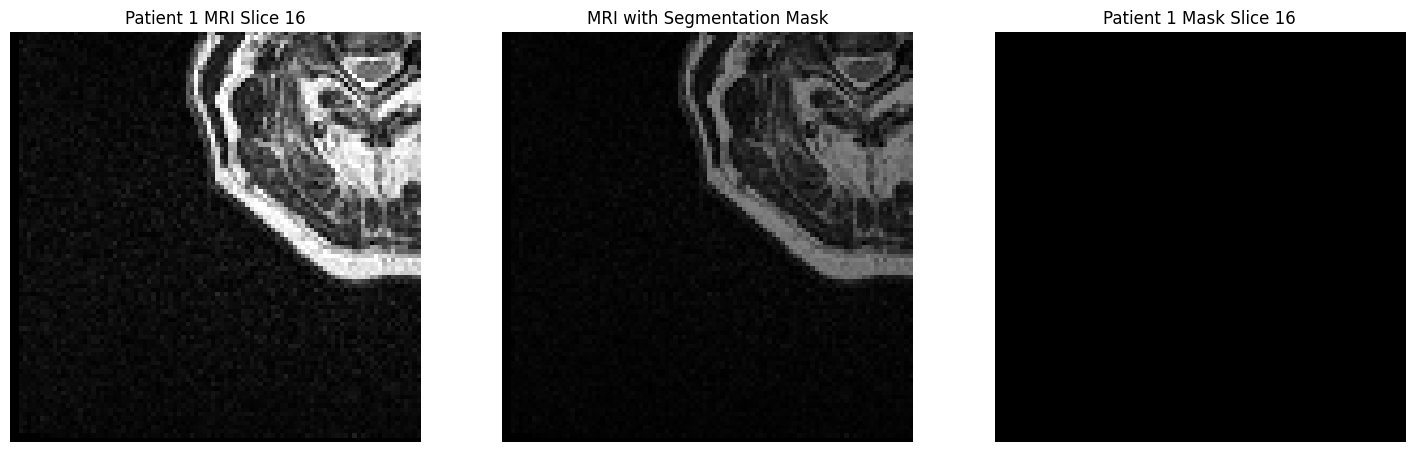

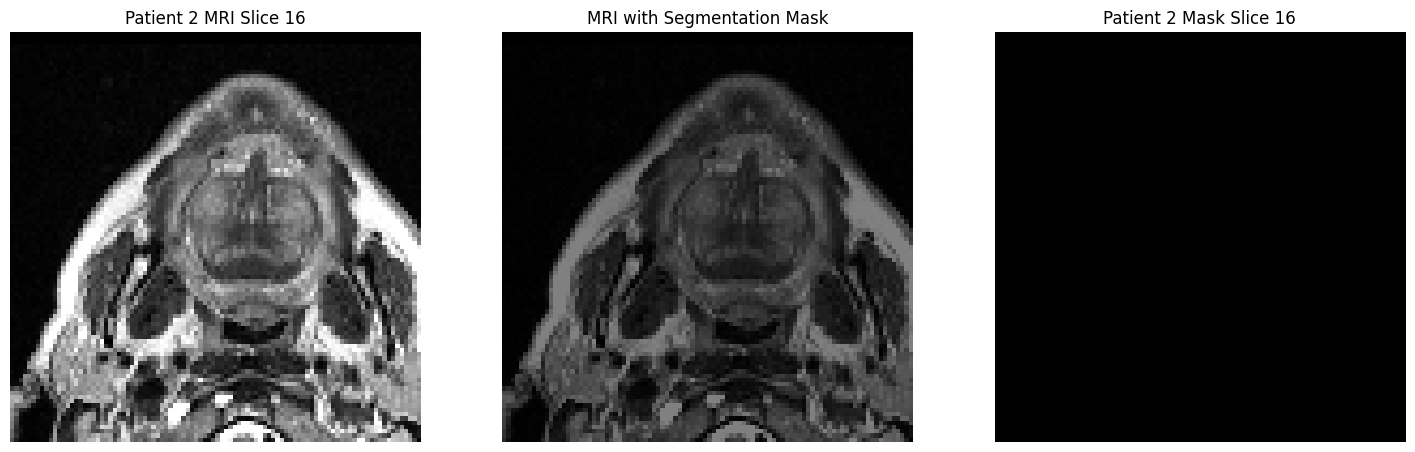


Train Batch 2:


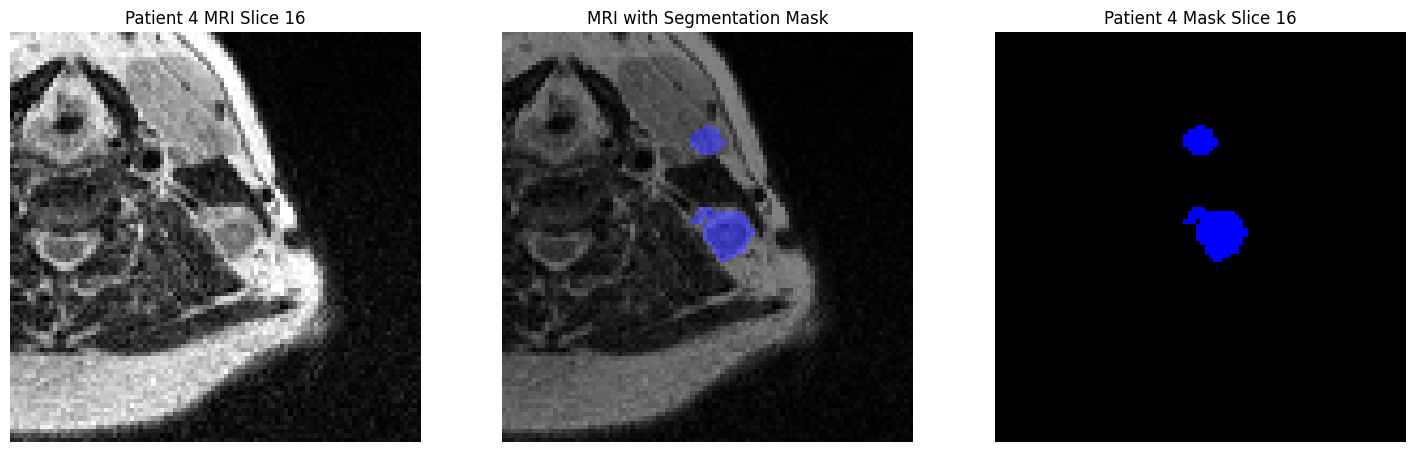

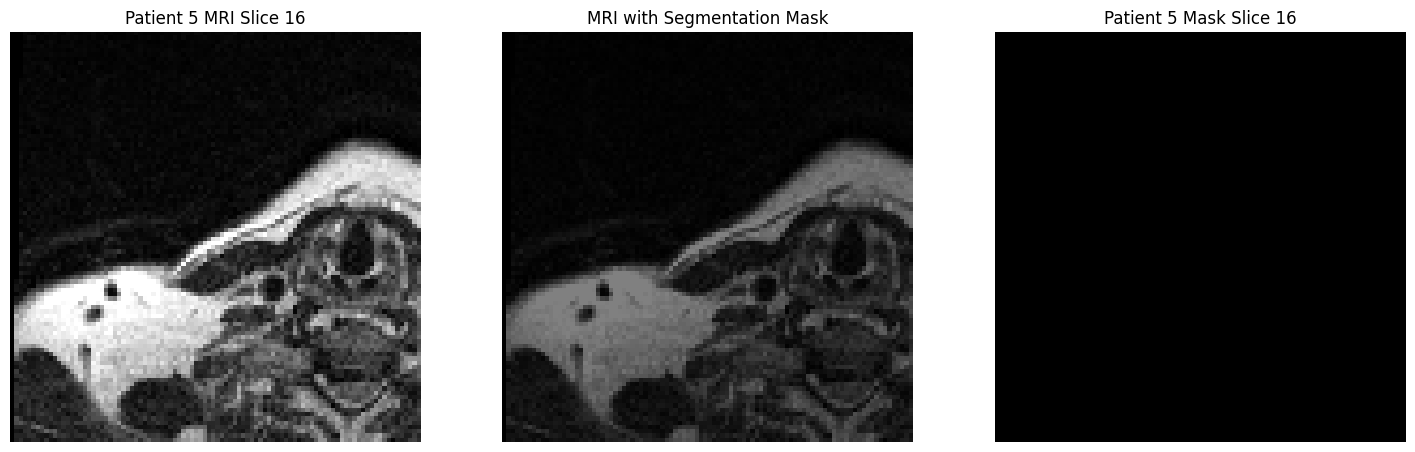


Validation Batch 1:


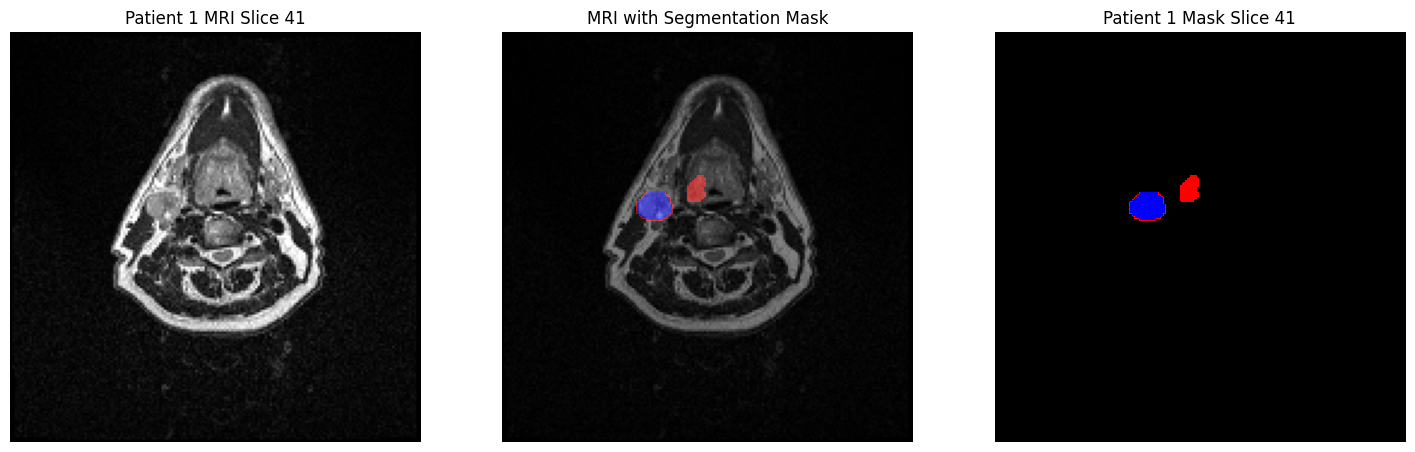

In [43]:
def plot_dataloader_sample(image_tensor, label_tensor, patient_id=None, slice_index=None):
    """
    Plots MRI image, MRI with segmentation mask overlay, and mask only.
    """
    image_np = image_tensor.cpu().numpy()
    label_np = label_tensor.cpu().numpy()

    if image_np.shape[0] == 1:
        image_np = np.squeeze(image_np, axis=0)

    if label_np.ndim == 4 and label_np.shape[0] == 1:
        label_np = np.squeeze(label_np, axis=0)

    if slice_index is None:
        slice_index = image_np.shape[2] // 2

    mri_slice = image_np[:, :, slice_index].T
    mask_slice = label_np[:, :, slice_index].T

    cmap = colors.ListedColormap(['black', 'red', 'blue'])
    norm = colors.BoundaryNorm([-0.5, 0.5, 1.5, 2.5], cmap.N)

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    axes[0].imshow(mri_slice, cmap='gray', origin='lower')
    title1 = f'Patient {patient_id} MRI Slice {slice_index}' if patient_id else f'MRI Slice {slice_index}'
    axes[0].set_title(title1)
    axes[0].axis('off')

    axes[1].imshow(mri_slice, cmap='gray', origin='lower')
    axes[1].imshow(mask_slice, cmap=cmap, norm=norm, alpha=0.5, origin='lower')
    axes[1].set_title('MRI with Segmentation Mask')
    axes[1].axis('off')

    axes[2].imshow(mask_slice, cmap=cmap, norm=norm, origin='lower')
    title3 = f'Patient {patient_id} Mask Slice {slice_index}' if patient_id else f'Mask Slice {slice_index}'
    axes[2].set_title(title3)
    axes[2].axis('off')

    plt.show()

def visualize_dataloader_samples(dataloader, num_batches=1, samples_per_batch=2, mode='Train'):
    """
    Visualizes samples from the dataloader.
    """
    for batch_idx, batch_data in enumerate(dataloader):
        if batch_idx >= num_batches:
            break

        images = batch_data["image"]
        labels = batch_data["label"]

        batch_size = images.shape[0]
        print(f"\n{mode} Batch {batch_idx + 1}:")
        for i in range(min(samples_per_batch, batch_size)):
            image = images[i]
            label = labels[i]
            patient_id = f"{batch_idx * dataloader.batch_size + i + 1}"
            plot_dataloader_sample(image, label, patient_id=patient_id)

# Example visualization
visualize_dataloader_samples(train_loader, num_batches=2, samples_per_batch=2, mode='Train')
visualize_dataloader_samples(val_loader, num_batches=1, samples_per_batch=1, mode='Validation')

**Prepare for usage of GPU**

In [44]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# **Step 5: Build Model**

**Initialize UNET Model**

In [45]:
model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=3,
    channels=(32, 64, 128, 256, 512),
    strides= (2, 2, 2, 2, 2),
    num_res_units=5,
    dropout=0.3,
    norm=Norm.BATCH,
).to(device)

# **Step 6: Train and Validate Model**

**Define Loss, Optimizer, and Metrics**

In [46]:
loss_function = DiceLoss(to_onehot_y=True, softmax=True)
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scaler = torch.cuda.amp.GradScaler()

post_label = AsDiscrete(to_onehot=NUM_CLASSES)
post_pred = AsDiscrete(argmax=True, to_onehot=NUM_CLASSES)
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)

**Training Loop**

In [47]:
# Post-processing for metrics
post_label = AsDiscrete(to_onehot=3)
post_pred = AsDiscrete(argmax=True, to_onehot=3)

# Initialize Dice metric
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)

# Initialize lists to store loss values
train_losses = []
val_losses = []
dice_scores = []

best_dice = 0.0  # Initialize best Dice score
best_epoch = 0  # To track which epoch had the best Dice score

# Initialize the scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='max',  # Because higher Dice score is better
    factor=SCHEDULER_FACTOR,
    patience=SCHEDULER_PATIENCE,
    verbose=True,
    min_lr=SCHEDULER_MIN_LR
)

# Training Loop
for epoch in range(NUM_EPOCHS):

    # ----------- Training Phase -----------
    model.train()
    epoch_loss = 0.0
    step = 0
    progress_bar = tqdm(train_loader, desc=f"Training epoch {epoch+1}/{NUM_EPOCHS}")

    for batch_data in progress_bar:
        step += 1

        # Retrieve training samples
        inputs = batch_data["image"].to(device)
        labels = batch_data["label"].to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        with torch.amp.autocast(str(device)):

            # Forward pass
            outputs = model(inputs)

            # Compute loss
            loss = loss_function(outputs, labels) / ACCUMULATION_STEPS

        # Backward pass
        scaler.scale(loss).backward()

        # Calculate epoch loss
        epoch_loss += loss.item() * ACCUMULATION_STEPS

        if step % ACCUMULATION_STEPS == 0:
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
        
        # Update progress bar
        progress_bar.set_postfix({"Loss": loss.item()*ACCUMULATION_STEPS})

    # Calculate average epoch loss
    avg_epoch_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_epoch_loss)


    # ----------- Validation Phase -----------
    model.eval()
    val_loss = 0.0
    dice_metric.reset()
    progress_bar = tqdm(val_loader, desc=f"Validation epoch {epoch+1}/{NUM_EPOCHS}")

    with torch.no_grad():
        for val_batch in progress_bar:

            # Retrieve validation samples
            val_inputs = val_batch["image"].cuda()
            val_labels = val_batch["label"].cuda()

            with torch.amp.autocast(str(device)):
                # Forward pass with sliding window inference for large images
                val_outputs = sliding_window_inference(val_inputs, (96, 96, 96), 4, model)

                if torch.isnan(val_outputs).any():
                    print("NaN detected in model outputs")

                # Compute validation loss
                loss = loss_function(val_outputs, val_labels)
                val_loss += loss.item()

            # Post-processing for Dice metric
            val_labels_list = decollate_batch(val_labels)
            val_labels_convert = [post_label(val_label_tensor) for val_label_tensor in val_labels_list]
            val_outputs_list = decollate_batch(val_outputs)
            val_output_convert = [post_pred(val_pred_tensor) for val_pred_tensor in val_outputs_list]
            dice_metric(y_pred=val_output_convert, y=val_labels_convert)

            # Update progress bar
            progress_bar.set_postfix({"Loss": loss.item()})
    
    # Calculate average validation loss and Dice score for the epoch
    avg_val_loss = val_loss / len(val_loader)
    dice_score = dice_metric.aggregate().item()
    dice_metric.reset()

    # Save losses
    val_losses.append(avg_val_loss)
    dice_scores.append(dice_score)

    # Step the scheduler based on validation Dice score
    scheduler.step(dice_score)

    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], "
          f"Train Loss: {avg_epoch_loss:.4f}, "
          f"Val Loss: {avg_val_loss:.4f}, "
          f"Dice Score: {dice_score:.4f}")


    # ----------- Model Checkpointing -----------
    if dice_score > best_dice:
        best_dice = dice_score
        best_epoch = epoch + 1
        torch.save(model.state_dict(), 'best_model.pth')  # Save the best model
        print(f"New best Dice score! Model saved at epoch {best_epoch} with Dice: {best_dice:.4f}")
    else:
        print(f"No improvement in Dice score this epoch.")


Validation epoch 1/250: 100%|██████████| 30/30 [00:03<00:00,  9.05it/s, Loss=0.773]


Epoch [1/250], Train Loss: 0.8000, Val Loss: 0.7789, Dice Score: 0.3486
New best Dice score! Model saved at epoch 1 with Dice: 0.3486


Validation epoch 2/250: 100%|██████████| 30/30 [00:03<00:00,  9.43it/s, Loss=0.762]


Epoch [2/250], Train Loss: 0.7758, Val Loss: 0.7661, Dice Score: 0.3594
New best Dice score! Model saved at epoch 2 with Dice: 0.3594


Validation epoch 3/250: 100%|██████████| 30/30 [00:03<00:00,  9.70it/s, Loss=0.741]


Epoch [3/250], Train Loss: 0.7611, Val Loss: 0.7448, Dice Score: 0.3655
New best Dice score! Model saved at epoch 3 with Dice: 0.3655


Validation epoch 4/250: 100%|██████████| 30/30 [00:03<00:00,  9.47it/s, Loss=0.728]


Epoch [4/250], Train Loss: 0.7478, Val Loss: 0.7336, Dice Score: 0.3650
No improvement in Dice score this epoch.


Validation epoch 5/250: 100%|██████████| 30/30 [00:03<00:00,  9.15it/s, Loss=0.724]


Epoch [5/250], Train Loss: 0.7370, Val Loss: 0.7255, Dice Score: 0.3681
New best Dice score! Model saved at epoch 5 with Dice: 0.3681


Validation epoch 6/250: 100%|██████████| 30/30 [00:03<00:00,  8.90it/s, Loss=0.719]


Epoch [6/250], Train Loss: 0.7276, Val Loss: 0.7192, Dice Score: 0.3729
New best Dice score! Model saved at epoch 6 with Dice: 0.3729


Validation epoch 7/250: 100%|██████████| 30/30 [00:03<00:00,  9.46it/s, Loss=0.719]


Epoch [7/250], Train Loss: 0.7188, Val Loss: 0.7199, Dice Score: 0.3737
New best Dice score! Model saved at epoch 7 with Dice: 0.3737


Validation epoch 8/250: 100%|██████████| 30/30 [00:03<00:00,  9.64it/s, Loss=0.702]


Epoch [8/250], Train Loss: 0.7109, Val Loss: 0.7028, Dice Score: 0.3655
No improvement in Dice score this epoch.


Validation epoch 9/250: 100%|██████████| 30/30 [00:03<00:00,  9.47it/s, Loss=0.691]


Epoch [9/250], Train Loss: 0.7025, Val Loss: 0.6917, Dice Score: 0.3772
New best Dice score! Model saved at epoch 9 with Dice: 0.3772


Validation epoch 10/250: 100%|██████████| 30/30 [00:03<00:00,  9.10it/s, Loss=0.703]


Epoch [10/250], Train Loss: 0.6932, Val Loss: 0.6956, Dice Score: 0.3871
New best Dice score! Model saved at epoch 10 with Dice: 0.3871


Validation epoch 11/250: 100%|██████████| 30/30 [00:03<00:00,  9.00it/s, Loss=0.704]


Epoch [11/250], Train Loss: 0.6850, Val Loss: 0.6951, Dice Score: 0.3814
No improvement in Dice score this epoch.


Validation epoch 12/250: 100%|██████████| 30/30 [00:03<00:00,  9.50it/s, Loss=0.691]


Epoch [12/250], Train Loss: 0.6771, Val Loss: 0.6718, Dice Score: 0.4088
New best Dice score! Model saved at epoch 12 with Dice: 0.4088


Validation epoch 13/250: 100%|██████████| 30/30 [00:03<00:00,  9.38it/s, Loss=0.686]


Epoch [13/250], Train Loss: 0.6634, Val Loss: 0.6742, Dice Score: 0.4280
New best Dice score! Model saved at epoch 13 with Dice: 0.4280


Validation epoch 14/250: 100%|██████████| 30/30 [00:03<00:00,  9.31it/s, Loss=0.678]


Epoch [14/250], Train Loss: 0.6519, Val Loss: 0.6589, Dice Score: 0.4080
No improvement in Dice score this epoch.


Validation epoch 15/250: 100%|██████████| 30/30 [00:03<00:00,  9.14it/s, Loss=0.676]


Epoch [15/250], Train Loss: 0.6417, Val Loss: 0.6603, Dice Score: 0.4454
New best Dice score! Model saved at epoch 15 with Dice: 0.4454


Validation epoch 16/250: 100%|██████████| 30/30 [00:03<00:00,  8.91it/s, Loss=0.675]


Epoch [16/250], Train Loss: 0.6275, Val Loss: 0.6409, Dice Score: 0.4880
New best Dice score! Model saved at epoch 16 with Dice: 0.4880


Validation epoch 17/250: 100%|██████████| 30/30 [00:03<00:00,  9.49it/s, Loss=0.669]


Epoch [17/250], Train Loss: 0.6158, Val Loss: 0.6304, Dice Score: 0.4458
No improvement in Dice score this epoch.


Validation epoch 18/250: 100%|██████████| 30/30 [00:03<00:00,  9.69it/s, Loss=0.683]


Epoch [18/250], Train Loss: 0.6105, Val Loss: 0.6513, Dice Score: 0.4601
No improvement in Dice score this epoch.


Validation epoch 19/250: 100%|██████████| 30/30 [00:03<00:00,  9.44it/s, Loss=0.667]


Epoch [19/250], Train Loss: 0.5969, Val Loss: 0.5930, Dice Score: 0.5194
New best Dice score! Model saved at epoch 19 with Dice: 0.5194


Validation epoch 20/250: 100%|██████████| 30/30 [00:03<00:00,  8.98it/s, Loss=0.668]


Epoch [20/250], Train Loss: 0.5819, Val Loss: 0.5628, Dice Score: 0.5405
New best Dice score! Model saved at epoch 20 with Dice: 0.5405


Validation epoch 21/250: 100%|██████████| 30/30 [00:03<00:00,  8.96it/s, Loss=0.673]


Epoch [21/250], Train Loss: 0.5779, Val Loss: 0.5965, Dice Score: 0.4992
No improvement in Dice score this epoch.


Validation epoch 22/250: 100%|██████████| 30/30 [00:03<00:00,  9.40it/s, Loss=0.672]


Epoch [22/250], Train Loss: 0.5694, Val Loss: 0.6145, Dice Score: 0.4725
No improvement in Dice score this epoch.


Validation epoch 23/250: 100%|██████████| 30/30 [00:03<00:00,  9.52it/s, Loss=0.67] 


Epoch [23/250], Train Loss: 0.5573, Val Loss: 0.6125, Dice Score: 0.4891
No improvement in Dice score this epoch.


Validation epoch 24/250: 100%|██████████| 30/30 [00:03<00:00,  9.44it/s, Loss=0.673]


Epoch [24/250], Train Loss: 0.5602, Val Loss: 0.5915, Dice Score: 0.5537
New best Dice score! Model saved at epoch 24 with Dice: 0.5537


Validation epoch 25/250: 100%|██████████| 30/30 [00:03<00:00,  8.96it/s, Loss=0.67] 


Epoch [25/250], Train Loss: 0.5483, Val Loss: 0.5974, Dice Score: 0.4852
No improvement in Dice score this epoch.


Validation epoch 26/250: 100%|██████████| 30/30 [00:03<00:00,  8.97it/s, Loss=0.671]


Epoch [26/250], Train Loss: 0.5397, Val Loss: 0.6013, Dice Score: 0.5462
No improvement in Dice score this epoch.


Validation epoch 27/250: 100%|██████████| 30/30 [00:03<00:00,  9.59it/s, Loss=0.667]


Epoch [27/250], Train Loss: 0.5359, Val Loss: 0.5538, Dice Score: 0.5232
No improvement in Dice score this epoch.


Validation epoch 28/250: 100%|██████████| 30/30 [00:03<00:00,  9.43it/s, Loss=0.648]


Epoch [28/250], Train Loss: 0.5276, Val Loss: 0.5141, Dice Score: 0.5719
New best Dice score! Model saved at epoch 28 with Dice: 0.5719


Validation epoch 29/250: 100%|██████████| 30/30 [00:03<00:00,  9.17it/s, Loss=0.662]


Epoch [29/250], Train Loss: 0.5335, Val Loss: 0.5387, Dice Score: 0.5597
No improvement in Dice score this epoch.


Validation epoch 30/250: 100%|██████████| 30/30 [00:03<00:00,  8.98it/s, Loss=0.667]


Epoch [30/250], Train Loss: 0.5371, Val Loss: 0.5453, Dice Score: 0.5623
No improvement in Dice score this epoch.


Validation epoch 31/250: 100%|██████████| 30/30 [00:03<00:00,  9.10it/s, Loss=0.669]


Epoch [31/250], Train Loss: 0.5157, Val Loss: 0.5722, Dice Score: 0.6009
New best Dice score! Model saved at epoch 31 with Dice: 0.6009


Validation epoch 32/250: 100%|██████████| 30/30 [00:02<00:00, 11.08it/s, Loss=0.668]


Epoch [32/250], Train Loss: 0.5020, Val Loss: 0.5263, Dice Score: 0.5823
No improvement in Dice score this epoch.


Validation epoch 33/250: 100%|██████████| 30/30 [00:02<00:00, 12.28it/s, Loss=0.659]


Epoch [33/250], Train Loss: 0.5032, Val Loss: 0.5377, Dice Score: 0.6146
New best Dice score! Model saved at epoch 33 with Dice: 0.6146


Validation epoch 34/250: 100%|██████████| 30/30 [00:03<00:00,  9.58it/s, Loss=0.664]


Epoch [34/250], Train Loss: 0.5182, Val Loss: 0.5503, Dice Score: 0.6036
No improvement in Dice score this epoch.


Validation epoch 35/250: 100%|██████████| 30/30 [00:03<00:00,  9.18it/s, Loss=0.654]


Epoch [35/250], Train Loss: 0.5059, Val Loss: 0.5036, Dice Score: 0.6089
No improvement in Dice score this epoch.


Validation epoch 36/250: 100%|██████████| 30/30 [00:03<00:00,  9.01it/s, Loss=0.658]


Epoch [36/250], Train Loss: 0.5010, Val Loss: 0.5054, Dice Score: 0.5889
No improvement in Dice score this epoch.


Validation epoch 37/250: 100%|██████████| 30/30 [00:03<00:00,  9.55it/s, Loss=0.661]


Epoch [37/250], Train Loss: 0.5064, Val Loss: 0.5307, Dice Score: 0.5500
No improvement in Dice score this epoch.


Validation epoch 38/250: 100%|██████████| 30/30 [00:03<00:00,  9.21it/s, Loss=0.667]


Epoch [38/250], Train Loss: 0.4933, Val Loss: 0.4692, Dice Score: 0.6219
New best Dice score! Model saved at epoch 38 with Dice: 0.6219


Validation epoch 39/250: 100%|██████████| 30/30 [00:03<00:00,  9.33it/s, Loss=0.669]


Epoch [39/250], Train Loss: 0.4928, Val Loss: 0.5342, Dice Score: 0.5792
No improvement in Dice score this epoch.


Validation epoch 40/250: 100%|██████████| 30/30 [00:03<00:00,  8.67it/s, Loss=0.669]


Epoch [40/250], Train Loss: 0.4949, Val Loss: 0.5088, Dice Score: 0.5885
No improvement in Dice score this epoch.


Validation epoch 41/250: 100%|██████████| 30/30 [00:03<00:00,  8.99it/s, Loss=0.667]


Epoch [41/250], Train Loss: 0.4865, Val Loss: 0.4895, Dice Score: 0.5886
No improvement in Dice score this epoch.


Validation epoch 42/250: 100%|██████████| 30/30 [00:03<00:00,  9.56it/s, Loss=0.668]


Epoch [42/250], Train Loss: 0.4900, Val Loss: 0.5007, Dice Score: 0.5836
No improvement in Dice score this epoch.


Validation epoch 43/250: 100%|██████████| 30/30 [00:03<00:00,  9.55it/s, Loss=0.667]


Epoch [43/250], Train Loss: 0.4918, Val Loss: 0.4695, Dice Score: 0.6056
No improvement in Dice score this epoch.


Validation epoch 44/250: 100%|██████████| 30/30 [00:03<00:00,  9.56it/s, Loss=0.665]


Epoch [44/250], Train Loss: 0.4868, Val Loss: 0.4758, Dice Score: 0.6110
No improvement in Dice score this epoch.


Validation epoch 45/250: 100%|██████████| 30/30 [00:03<00:00,  9.12it/s, Loss=0.667]


Epoch [45/250], Train Loss: 0.4894, Val Loss: 0.4846, Dice Score: 0.6012
No improvement in Dice score this epoch.


Validation epoch 46/250: 100%|██████████| 30/30 [00:03<00:00,  9.17it/s, Loss=0.644]


Epoch [46/250], Train Loss: 0.4829, Val Loss: 0.4484, Dice Score: 0.6353
New best Dice score! Model saved at epoch 46 with Dice: 0.6353


Validation epoch 47/250: 100%|██████████| 30/30 [00:03<00:00,  9.56it/s, Loss=0.634]


Epoch [47/250], Train Loss: 0.4819, Val Loss: 0.4623, Dice Score: 0.6163
No improvement in Dice score this epoch.


Validation epoch 48/250: 100%|██████████| 30/30 [00:03<00:00,  9.85it/s, Loss=0.652]


Epoch [48/250], Train Loss: 0.4840, Val Loss: 0.4741, Dice Score: 0.6105
No improvement in Dice score this epoch.


Validation epoch 49/250: 100%|██████████| 30/30 [00:03<00:00,  9.67it/s, Loss=0.665]


Epoch [49/250], Train Loss: 0.4905, Val Loss: 0.4640, Dice Score: 0.6089
No improvement in Dice score this epoch.


Validation epoch 50/250: 100%|██████████| 30/30 [00:03<00:00,  9.79it/s, Loss=0.667]


Epoch [50/250], Train Loss: 0.4795, Val Loss: 0.4627, Dice Score: 0.6060
No improvement in Dice score this epoch.


Validation epoch 51/250: 100%|██████████| 30/30 [00:03<00:00,  9.19it/s, Loss=0.662]


Epoch [51/250], Train Loss: 0.4870, Val Loss: 0.4620, Dice Score: 0.6153
No improvement in Dice score this epoch.


Validation epoch 52/250: 100%|██████████| 30/30 [00:02<00:00, 14.92it/s, Loss=0.667]


Epoch [52/250], Train Loss: 0.4795, Val Loss: 0.4787, Dice Score: 0.5795
No improvement in Dice score this epoch.


Validation epoch 53/250: 100%|██████████| 30/30 [00:03<00:00,  9.53it/s, Loss=0.667]


Epoch [53/250], Train Loss: 0.4759, Val Loss: 0.4738, Dice Score: 0.5944
No improvement in Dice score this epoch.


Validation epoch 54/250: 100%|██████████| 30/30 [00:03<00:00,  9.59it/s, Loss=0.667]


Epoch [54/250], Train Loss: 0.4746, Val Loss: 0.4609, Dice Score: 0.6020
No improvement in Dice score this epoch.


Validation epoch 55/250: 100%|██████████| 30/30 [00:03<00:00,  9.30it/s, Loss=0.638]


Epoch [55/250], Train Loss: 0.4597, Val Loss: 0.4467, Dice Score: 0.6199
No improvement in Dice score this epoch.


Validation epoch 56/250: 100%|██████████| 30/30 [00:03<00:00,  9.03it/s, Loss=0.576]


Epoch [56/250], Train Loss: 0.4724, Val Loss: 0.4334, Dice Score: 0.6340
No improvement in Dice score this epoch.


Validation epoch 57/250: 100%|██████████| 30/30 [00:03<00:00,  9.06it/s, Loss=0.663]


Epoch [57/250], Train Loss: 0.4806, Val Loss: 0.4638, Dice Score: 0.5994
No improvement in Dice score this epoch.


Validation epoch 58/250: 100%|██████████| 30/30 [00:03<00:00,  9.47it/s, Loss=0.667]


Epoch [58/250], Train Loss: 0.4624, Val Loss: 0.4472, Dice Score: 0.6181
No improvement in Dice score this epoch.


Validation epoch 59/250: 100%|██████████| 30/30 [00:03<00:00,  9.80it/s, Loss=0.635]


Epoch [59/250], Train Loss: 0.4779, Val Loss: 0.4432, Dice Score: 0.6160
No improvement in Dice score this epoch.


Validation epoch 60/250: 100%|██████████| 30/30 [00:03<00:00,  9.39it/s, Loss=0.667]


Epoch [60/250], Train Loss: 0.4494, Val Loss: 0.4460, Dice Score: 0.6142
No improvement in Dice score this epoch.


Validation epoch 61/250: 100%|██████████| 30/30 [00:03<00:00,  9.18it/s, Loss=0.621]


Epoch [61/250], Train Loss: 0.4706, Val Loss: 0.4368, Dice Score: 0.6385
New best Dice score! Model saved at epoch 61 with Dice: 0.6385


Validation epoch 62/250: 100%|██████████| 30/30 [00:03<00:00,  8.99it/s, Loss=0.665]


Epoch [62/250], Train Loss: 0.4558, Val Loss: 0.4514, Dice Score: 0.6056
No improvement in Dice score this epoch.


Validation epoch 63/250: 100%|██████████| 30/30 [00:03<00:00,  9.90it/s, Loss=0.667]


Epoch [63/250], Train Loss: 0.4617, Val Loss: 0.4493, Dice Score: 0.6104
No improvement in Dice score this epoch.


Validation epoch 64/250: 100%|██████████| 30/30 [00:03<00:00,  9.45it/s, Loss=0.632]


Epoch [64/250], Train Loss: 0.4591, Val Loss: 0.4336, Dice Score: 0.6445
New best Dice score! Model saved at epoch 64 with Dice: 0.6445


Validation epoch 65/250: 100%|██████████| 30/30 [00:03<00:00,  9.41it/s, Loss=0.587]


Epoch [65/250], Train Loss: 0.4749, Val Loss: 0.4211, Dice Score: 0.6449
New best Dice score! Model saved at epoch 65 with Dice: 0.6449


Validation epoch 66/250: 100%|██████████| 30/30 [00:03<00:00,  9.19it/s, Loss=0.584]


Epoch [66/250], Train Loss: 0.4578, Val Loss: 0.4370, Dice Score: 0.6338
No improvement in Dice score this epoch.


Validation epoch 67/250: 100%|██████████| 30/30 [00:03<00:00,  9.09it/s, Loss=0.579]


Epoch [67/250], Train Loss: 0.4550, Val Loss: 0.4347, Dice Score: 0.6282
No improvement in Dice score this epoch.


Validation epoch 68/250: 100%|██████████| 30/30 [00:03<00:00,  9.45it/s, Loss=0.627]


Epoch [68/250], Train Loss: 0.4646, Val Loss: 0.4168, Dice Score: 0.6490
New best Dice score! Model saved at epoch 68 with Dice: 0.6490


Validation epoch 69/250: 100%|██████████| 30/30 [00:03<00:00,  9.64it/s, Loss=0.593]


Epoch [69/250], Train Loss: 0.4510, Val Loss: 0.3967, Dice Score: 0.6688
New best Dice score! Model saved at epoch 69 with Dice: 0.6688


Validation epoch 70/250: 100%|██████████| 30/30 [00:03<00:00,  9.57it/s, Loss=0.656]


Epoch [70/250], Train Loss: 0.4439, Val Loss: 0.4232, Dice Score: 0.6416
No improvement in Dice score this epoch.


Validation epoch 71/250: 100%|██████████| 30/30 [00:03<00:00,  9.17it/s, Loss=0.643]


Epoch [71/250], Train Loss: 0.4575, Val Loss: 0.4595, Dice Score: 0.5956
No improvement in Dice score this epoch.


Validation epoch 72/250: 100%|██████████| 30/30 [00:03<00:00,  9.10it/s, Loss=0.546]


Epoch [72/250], Train Loss: 0.4578, Val Loss: 0.3980, Dice Score: 0.6635
No improvement in Dice score this epoch.


Validation epoch 73/250: 100%|██████████| 30/30 [00:03<00:00,  9.41it/s, Loss=0.66] 


Epoch [73/250], Train Loss: 0.4579, Val Loss: 0.4251, Dice Score: 0.6341
No improvement in Dice score this epoch.


Validation epoch 74/250: 100%|██████████| 30/30 [00:03<00:00,  9.66it/s, Loss=0.664]


Epoch [74/250], Train Loss: 0.4557, Val Loss: 0.4598, Dice Score: 0.5960
No improvement in Dice score this epoch.


Validation epoch 75/250: 100%|██████████| 30/30 [00:03<00:00,  9.75it/s, Loss=0.665]


Epoch [75/250], Train Loss: 0.4452, Val Loss: 0.4292, Dice Score: 0.6331
No improvement in Dice score this epoch.


Validation epoch 76/250: 100%|██████████| 30/30 [00:03<00:00,  9.87it/s, Loss=0.663]


Epoch [76/250], Train Loss: 0.4584, Val Loss: 0.4054, Dice Score: 0.6557
No improvement in Dice score this epoch.


Validation epoch 77/250: 100%|██████████| 30/30 [00:03<00:00,  9.01it/s, Loss=0.655]


Epoch [77/250], Train Loss: 0.4525, Val Loss: 0.4503, Dice Score: 0.6083
No improvement in Dice score this epoch.


Validation epoch 78/250: 100%|██████████| 30/30 [00:03<00:00,  9.34it/s, Loss=0.667]


Epoch [78/250], Train Loss: 0.4500, Val Loss: 0.4050, Dice Score: 0.6578
No improvement in Dice score this epoch.


Validation epoch 79/250: 100%|██████████| 30/30 [00:03<00:00,  9.68it/s, Loss=0.625]


Epoch [79/250], Train Loss: 0.4504, Val Loss: 0.3931, Dice Score: 0.6694
New best Dice score! Model saved at epoch 79 with Dice: 0.6694


Validation epoch 80/250: 100%|██████████| 30/30 [00:03<00:00,  9.91it/s, Loss=0.65] 


Epoch [80/250], Train Loss: 0.4422, Val Loss: 0.4019, Dice Score: 0.6597
No improvement in Dice score this epoch.


Validation epoch 81/250: 100%|██████████| 30/30 [00:03<00:00,  9.27it/s, Loss=0.665]


Epoch [81/250], Train Loss: 0.4437, Val Loss: 0.3925, Dice Score: 0.6693
No improvement in Dice score this epoch.


Validation epoch 82/250: 100%|██████████| 30/30 [00:03<00:00,  9.01it/s, Loss=0.665]


Epoch [82/250], Train Loss: 0.4518, Val Loss: 0.4340, Dice Score: 0.6229
No improvement in Dice score this epoch.


Validation epoch 83/250: 100%|██████████| 30/30 [00:03<00:00,  9.10it/s, Loss=0.579]


Epoch [83/250], Train Loss: 0.4387, Val Loss: 0.4028, Dice Score: 0.6590
No improvement in Dice score this epoch.


Validation epoch 84/250: 100%|██████████| 30/30 [00:03<00:00,  9.50it/s, Loss=0.57] 


Epoch [84/250], Train Loss: 0.4516, Val Loss: 0.3986, Dice Score: 0.6654
No improvement in Dice score this epoch.


Validation epoch 85/250: 100%|██████████| 30/30 [00:03<00:00,  9.68it/s, Loss=0.604]


Epoch [85/250], Train Loss: 0.4502, Val Loss: 0.4052, Dice Score: 0.6560
No improvement in Dice score this epoch.


Validation epoch 86/250: 100%|██████████| 30/30 [00:03<00:00,  9.45it/s, Loss=0.667]


Epoch [86/250], Train Loss: 0.4416, Val Loss: 0.4218, Dice Score: 0.6340
No improvement in Dice score this epoch.


Validation epoch 87/250: 100%|██████████| 30/30 [00:03<00:00,  9.20it/s, Loss=0.481]


Epoch [87/250], Train Loss: 0.4392, Val Loss: 0.3943, Dice Score: 0.6670
No improvement in Dice score this epoch.


Validation epoch 88/250: 100%|██████████| 30/30 [00:03<00:00,  8.96it/s, Loss=0.52] 


Epoch [88/250], Train Loss: 0.4420, Val Loss: 0.4423, Dice Score: 0.6153
No improvement in Dice score this epoch.


Validation epoch 89/250: 100%|██████████| 30/30 [00:03<00:00,  9.58it/s, Loss=0.487]


Epoch [89/250], Train Loss: 0.4380, Val Loss: 0.3905, Dice Score: 0.6722
New best Dice score! Model saved at epoch 89 with Dice: 0.6722


Validation epoch 90/250: 100%|██████████| 30/30 [00:03<00:00,  9.59it/s, Loss=0.58] 


Epoch [90/250], Train Loss: 0.4421, Val Loss: 0.4106, Dice Score: 0.6462
No improvement in Dice score this epoch.


Validation epoch 91/250: 100%|██████████| 30/30 [00:03<00:00,  9.34it/s, Loss=0.667]


Epoch [91/250], Train Loss: 0.4488, Val Loss: 0.4167, Dice Score: 0.6391
No improvement in Dice score this epoch.


Validation epoch 92/250: 100%|██████████| 30/30 [00:03<00:00,  9.12it/s, Loss=0.648]


Epoch [92/250], Train Loss: 0.4404, Val Loss: 0.4281, Dice Score: 0.6304
No improvement in Dice score this epoch.


Validation epoch 93/250: 100%|██████████| 30/30 [00:03<00:00,  9.02it/s, Loss=0.532]


Epoch [93/250], Train Loss: 0.4335, Val Loss: 0.4214, Dice Score: 0.6367
No improvement in Dice score this epoch.


Validation epoch 94/250: 100%|██████████| 30/30 [00:03<00:00,  9.71it/s, Loss=0.667]


Epoch [94/250], Train Loss: 0.4452, Val Loss: 0.4484, Dice Score: 0.6037
No improvement in Dice score this epoch.


Validation epoch 95/250: 100%|██████████| 30/30 [00:03<00:00,  9.39it/s, Loss=0.667]


Epoch [95/250], Train Loss: 0.4427, Val Loss: 0.4120, Dice Score: 0.6435
No improvement in Dice score this epoch.


Validation epoch 96/250: 100%|██████████| 30/30 [00:03<00:00,  9.58it/s, Loss=0.649]


Epoch [96/250], Train Loss: 0.4362, Val Loss: 0.3881, Dice Score: 0.6694
No improvement in Dice score this epoch.


Validation epoch 97/250: 100%|██████████| 30/30 [00:03<00:00,  9.22it/s, Loss=0.55] 


Epoch [97/250], Train Loss: 0.4256, Val Loss: 0.3864, Dice Score: 0.6725
New best Dice score! Model saved at epoch 97 with Dice: 0.6725


Validation epoch 98/250: 100%|██████████| 30/30 [00:03<00:00,  9.07it/s, Loss=0.667]


Epoch [98/250], Train Loss: 0.4423, Val Loss: 0.4456, Dice Score: 0.6073
No improvement in Dice score this epoch.


Validation epoch 99/250: 100%|██████████| 30/30 [00:03<00:00,  9.67it/s, Loss=0.664]


Epoch [99/250], Train Loss: 0.4360, Val Loss: 0.4232, Dice Score: 0.6330
No improvement in Dice score this epoch.


Validation epoch 100/250: 100%|██████████| 30/30 [00:03<00:00,  9.47it/s, Loss=0.597]


Epoch [100/250], Train Loss: 0.4300, Val Loss: 0.4029, Dice Score: 0.6547
No improvement in Dice score this epoch.


Validation epoch 101/250: 100%|██████████| 30/30 [00:03<00:00,  9.48it/s, Loss=0.667]


Epoch [101/250], Train Loss: 0.4308, Val Loss: 0.3961, Dice Score: 0.6612
No improvement in Dice score this epoch.


Validation epoch 102/250: 100%|██████████| 30/30 [00:03<00:00,  9.77it/s, Loss=0.667]


Epoch [102/250], Train Loss: 0.4386, Val Loss: 0.3940, Dice Score: 0.6642
No improvement in Dice score this epoch.


Validation epoch 103/250: 100%|██████████| 30/30 [00:03<00:00,  9.06it/s, Loss=0.659]


Epoch [103/250], Train Loss: 0.4318, Val Loss: 0.3986, Dice Score: 0.6579
No improvement in Dice score this epoch.


Validation epoch 104/250: 100%|██████████| 30/30 [00:03<00:00,  9.32it/s, Loss=0.667]


Epoch [104/250], Train Loss: 0.4385, Val Loss: 0.4313, Dice Score: 0.6239
No improvement in Dice score this epoch.


Validation epoch 105/250: 100%|██████████| 30/30 [00:03<00:00,  9.76it/s, Loss=0.667]


Epoch [105/250], Train Loss: 0.4275, Val Loss: 0.4194, Dice Score: 0.6337
No improvement in Dice score this epoch.


Validation epoch 106/250: 100%|██████████| 30/30 [00:03<00:00,  9.79it/s, Loss=0.667]


Epoch [106/250], Train Loss: 0.4399, Val Loss: 0.4172, Dice Score: 0.6376
No improvement in Dice score this epoch.


Validation epoch 107/250: 100%|██████████| 30/30 [00:03<00:00,  9.30it/s, Loss=0.667]


Epoch [107/250], Train Loss: 0.4259, Val Loss: 0.3869, Dice Score: 0.6687
No improvement in Dice score this epoch.


Validation epoch 108/250: 100%|██████████| 30/30 [00:03<00:00,  9.00it/s, Loss=0.592]


Epoch [108/250], Train Loss: 0.4243, Val Loss: 0.3867, Dice Score: 0.6697
No improvement in Dice score this epoch.


Validation epoch 109/250: 100%|██████████| 30/30 [00:03<00:00,  9.08it/s, Loss=0.634]


Epoch [109/250], Train Loss: 0.4364, Val Loss: 0.3898, Dice Score: 0.6678
No improvement in Dice score this epoch.


Validation epoch 110/250: 100%|██████████| 30/30 [00:03<00:00,  9.38it/s, Loss=0.667]


Epoch [110/250], Train Loss: 0.4354, Val Loss: 0.3912, Dice Score: 0.6655
No improvement in Dice score this epoch.


Validation epoch 111/250: 100%|██████████| 30/30 [00:03<00:00,  9.34it/s, Loss=0.667]


Epoch [111/250], Train Loss: 0.4348, Val Loss: 0.4294, Dice Score: 0.6252
No improvement in Dice score this epoch.


Validation epoch 112/250: 100%|██████████| 30/30 [00:03<00:00,  9.73it/s, Loss=0.667]


Epoch [112/250], Train Loss: 0.4380, Val Loss: 0.4233, Dice Score: 0.6325
No improvement in Dice score this epoch.


Validation epoch 113/250: 100%|██████████| 30/30 [00:03<00:00,  9.13it/s, Loss=0.66] 


Epoch [113/250], Train Loss: 0.4180, Val Loss: 0.3917, Dice Score: 0.6657
No improvement in Dice score this epoch.


Validation epoch 114/250: 100%|██████████| 30/30 [00:03<00:00,  9.02it/s, Loss=0.667]


Epoch [114/250], Train Loss: 0.4187, Val Loss: 0.4601, Dice Score: 0.5896
No improvement in Dice score this epoch.


Validation epoch 115/250: 100%|██████████| 30/30 [00:03<00:00,  9.42it/s, Loss=0.667]


Epoch [115/250], Train Loss: 0.4346, Val Loss: 0.4048, Dice Score: 0.6493
No improvement in Dice score this epoch.


Validation epoch 116/250: 100%|██████████| 30/30 [00:03<00:00,  9.41it/s, Loss=0.661]


Epoch [116/250], Train Loss: 0.4290, Val Loss: 0.3900, Dice Score: 0.6672
No improvement in Dice score this epoch.


Validation epoch 117/250: 100%|██████████| 30/30 [00:03<00:00,  9.61it/s, Loss=0.66] 


Epoch [117/250], Train Loss: 0.4235, Val Loss: 0.4051, Dice Score: 0.6523
No improvement in Dice score this epoch.


Validation epoch 118/250: 100%|██████████| 30/30 [00:03<00:00,  9.12it/s, Loss=0.667]


Epoch [118/250], Train Loss: 0.4101, Val Loss: 0.4117, Dice Score: 0.6449
No improvement in Dice score this epoch.


Validation epoch 119/250: 100%|██████████| 30/30 [00:03<00:00,  9.09it/s, Loss=0.665]


Epoch [119/250], Train Loss: 0.4162, Val Loss: 0.3841, Dice Score: 0.6752
New best Dice score! Model saved at epoch 119 with Dice: 0.6752


Validation epoch 120/250: 100%|██████████| 30/30 [00:03<00:00,  9.57it/s, Loss=0.667]


Epoch [120/250], Train Loss: 0.4294, Val Loss: 0.4168, Dice Score: 0.6396
No improvement in Dice score this epoch.


Validation epoch 121/250: 100%|██████████| 30/30 [00:03<00:00,  9.44it/s, Loss=0.663]


Epoch [121/250], Train Loss: 0.4151, Val Loss: 0.3989, Dice Score: 0.6579
No improvement in Dice score this epoch.


Validation epoch 122/250: 100%|██████████| 30/30 [00:03<00:00,  9.68it/s, Loss=0.667]


Epoch [122/250], Train Loss: 0.4151, Val Loss: 0.3973, Dice Score: 0.6600
No improvement in Dice score this epoch.


Validation epoch 123/250: 100%|██████████| 30/30 [00:03<00:00,  9.18it/s, Loss=0.667]


Epoch [123/250], Train Loss: 0.4089, Val Loss: 0.3812, Dice Score: 0.6769
New best Dice score! Model saved at epoch 123 with Dice: 0.6769


Validation epoch 124/250: 100%|██████████| 30/30 [00:03<00:00,  9.18it/s, Loss=0.667]


Epoch [124/250], Train Loss: 0.4226, Val Loss: 0.3956, Dice Score: 0.6625
No improvement in Dice score this epoch.


Validation epoch 125/250: 100%|██████████| 30/30 [00:03<00:00,  9.62it/s, Loss=0.667]


Epoch [125/250], Train Loss: 0.4177, Val Loss: 0.4094, Dice Score: 0.6467
No improvement in Dice score this epoch.


Validation epoch 126/250: 100%|██████████| 30/30 [00:03<00:00,  9.76it/s, Loss=0.641]


Epoch [126/250], Train Loss: 0.4135, Val Loss: 0.4004, Dice Score: 0.6551
No improvement in Dice score this epoch.


Validation epoch 127/250: 100%|██████████| 30/30 [00:03<00:00,  9.47it/s, Loss=0.667]


Epoch [127/250], Train Loss: 0.4074, Val Loss: 0.4042, Dice Score: 0.6490
No improvement in Dice score this epoch.


Validation epoch 128/250: 100%|██████████| 30/30 [00:03<00:00,  9.77it/s, Loss=0.666]


Epoch [128/250], Train Loss: 0.4158, Val Loss: 0.4240, Dice Score: 0.6309
No improvement in Dice score this epoch.


Validation epoch 129/250: 100%|██████████| 30/30 [00:03<00:00,  9.09it/s, Loss=0.645]


Epoch [129/250], Train Loss: 0.4217, Val Loss: 0.4021, Dice Score: 0.6536
No improvement in Dice score this epoch.


Validation epoch 130/250: 100%|██████████| 30/30 [00:03<00:00,  9.23it/s, Loss=0.667]


Epoch [130/250], Train Loss: 0.4151, Val Loss: 0.4160, Dice Score: 0.6396
No improvement in Dice score this epoch.


Validation epoch 131/250: 100%|██████████| 30/30 [00:03<00:00,  9.64it/s, Loss=0.667]


Epoch [131/250], Train Loss: 0.4122, Val Loss: 0.3998, Dice Score: 0.6559
No improvement in Dice score this epoch.


Validation epoch 132/250: 100%|██████████| 30/30 [00:03<00:00,  9.36it/s, Loss=0.667]


Epoch [132/250], Train Loss: 0.4160, Val Loss: 0.4123, Dice Score: 0.6436
No improvement in Dice score this epoch.


Validation epoch 133/250: 100%|██████████| 30/30 [00:03<00:00,  9.22it/s, Loss=0.61] 


Epoch [133/250], Train Loss: 0.4090, Val Loss: 0.3798, Dice Score: 0.6782
New best Dice score! Model saved at epoch 133 with Dice: 0.6782


Validation epoch 134/250: 100%|██████████| 30/30 [00:03<00:00,  8.94it/s, Loss=0.667]


Epoch [134/250], Train Loss: 0.4280, Val Loss: 0.3920, Dice Score: 0.6658
No improvement in Dice score this epoch.


Validation epoch 135/250: 100%|██████████| 30/30 [00:03<00:00,  8.99it/s, Loss=0.667]


Epoch [135/250], Train Loss: 0.4208, Val Loss: 0.4218, Dice Score: 0.6323
No improvement in Dice score this epoch.


Validation epoch 136/250: 100%|██████████| 30/30 [00:03<00:00,  9.58it/s, Loss=0.667]


Epoch [136/250], Train Loss: 0.4230, Val Loss: 0.4024, Dice Score: 0.6543
No improvement in Dice score this epoch.


Validation epoch 137/250: 100%|██████████| 30/30 [00:03<00:00,  9.47it/s, Loss=0.648]


Epoch [137/250], Train Loss: 0.4151, Val Loss: 0.4161, Dice Score: 0.6375
No improvement in Dice score this epoch.


Validation epoch 138/250: 100%|██████████| 30/30 [00:03<00:00,  9.63it/s, Loss=0.667]


Epoch [138/250], Train Loss: 0.4126, Val Loss: 0.3859, Dice Score: 0.6715
No improvement in Dice score this epoch.


Validation epoch 139/250: 100%|██████████| 30/30 [00:03<00:00,  9.07it/s, Loss=0.667]


Epoch [139/250], Train Loss: 0.4160, Val Loss: 0.4327, Dice Score: 0.6214
No improvement in Dice score this epoch.


Validation epoch 140/250: 100%|██████████| 30/30 [00:03<00:00,  8.97it/s, Loss=0.667]


Epoch [140/250], Train Loss: 0.4060, Val Loss: 0.3979, Dice Score: 0.6576
No improvement in Dice score this epoch.


Validation epoch 141/250: 100%|██████████| 30/30 [00:03<00:00,  9.43it/s, Loss=0.667]


Epoch [141/250], Train Loss: 0.4034, Val Loss: 0.4238, Dice Score: 0.6321
No improvement in Dice score this epoch.


Validation epoch 142/250: 100%|██████████| 30/30 [00:03<00:00,  9.49it/s, Loss=0.638]


Epoch [142/250], Train Loss: 0.4060, Val Loss: 0.4102, Dice Score: 0.6464
No improvement in Dice score this epoch.


Validation epoch 143/250: 100%|██████████| 30/30 [00:03<00:00,  9.50it/s, Loss=0.667]


Epoch [143/250], Train Loss: 0.4278, Val Loss: 0.3918, Dice Score: 0.6652
No improvement in Dice score this epoch.


Validation epoch 144/250: 100%|██████████| 30/30 [00:03<00:00,  9.13it/s, Loss=0.6]  


Epoch [144/250], Train Loss: 0.4034, Val Loss: 0.3792, Dice Score: 0.6800
New best Dice score! Model saved at epoch 144 with Dice: 0.6800


Validation epoch 145/250: 100%|██████████| 30/30 [00:03<00:00,  9.08it/s, Loss=0.667]


Epoch [145/250], Train Loss: 0.4146, Val Loss: 0.4009, Dice Score: 0.6550
No improvement in Dice score this epoch.


Validation epoch 146/250: 100%|██████████| 30/30 [00:03<00:00,  9.69it/s, Loss=0.667]


Epoch [146/250], Train Loss: 0.4222, Val Loss: 0.3776, Dice Score: 0.6802
New best Dice score! Model saved at epoch 146 with Dice: 0.6802


Validation epoch 147/250: 100%|██████████| 30/30 [00:03<00:00,  9.46it/s, Loss=0.634]


Epoch [147/250], Train Loss: 0.4102, Val Loss: 0.3673, Dice Score: 0.6917
New best Dice score! Model saved at epoch 147 with Dice: 0.6917


Validation epoch 148/250: 100%|██████████| 30/30 [00:03<00:00,  9.38it/s, Loss=0.667]


Epoch [148/250], Train Loss: 0.4055, Val Loss: 0.4415, Dice Score: 0.6114
No improvement in Dice score this epoch.


Validation epoch 149/250: 100%|██████████| 30/30 [00:03<00:00,  9.19it/s, Loss=0.667]


Epoch [149/250], Train Loss: 0.4203, Val Loss: 0.4003, Dice Score: 0.6564
No improvement in Dice score this epoch.


Validation epoch 150/250: 100%|██████████| 30/30 [00:03<00:00,  9.13it/s, Loss=0.667]


Epoch [150/250], Train Loss: 0.4152, Val Loss: 0.4165, Dice Score: 0.6380
No improvement in Dice score this epoch.


Validation epoch 151/250: 100%|██████████| 30/30 [00:03<00:00,  9.48it/s, Loss=0.667]


Epoch [151/250], Train Loss: 0.4167, Val Loss: 0.3911, Dice Score: 0.6657
No improvement in Dice score this epoch.


Validation epoch 152/250: 100%|██████████| 30/30 [00:03<00:00,  9.54it/s, Loss=0.667]


Epoch [152/250], Train Loss: 0.4120, Val Loss: 0.3789, Dice Score: 0.6783
No improvement in Dice score this epoch.


Validation epoch 153/250: 100%|██████████| 30/30 [00:03<00:00,  9.64it/s, Loss=0.667]


Epoch [153/250], Train Loss: 0.4004, Val Loss: 0.4074, Dice Score: 0.6466
No improvement in Dice score this epoch.


Validation epoch 154/250: 100%|██████████| 30/30 [00:03<00:00,  9.77it/s, Loss=0.667]


Epoch [154/250], Train Loss: 0.4144, Val Loss: 0.4017, Dice Score: 0.6557
No improvement in Dice score this epoch.


Validation epoch 155/250: 100%|██████████| 30/30 [00:03<00:00,  9.06it/s, Loss=0.576]


Epoch [155/250], Train Loss: 0.4224, Val Loss: 0.3831, Dice Score: 0.6774
No improvement in Dice score this epoch.


Validation epoch 156/250: 100%|██████████| 30/30 [00:03<00:00,  9.51it/s, Loss=0.667]


Epoch [156/250], Train Loss: 0.4157, Val Loss: 0.3902, Dice Score: 0.6672
No improvement in Dice score this epoch.


Validation epoch 157/250: 100%|██████████| 30/30 [00:03<00:00,  9.49it/s, Loss=0.667]


Epoch [157/250], Train Loss: 0.4038, Val Loss: 0.3823, Dice Score: 0.6751
No improvement in Dice score this epoch.


Validation epoch 158/250: 100%|██████████| 30/30 [00:03<00:00,  9.59it/s, Loss=0.661]


Epoch [158/250], Train Loss: 0.4075, Val Loss: 0.3765, Dice Score: 0.6820
No improvement in Dice score this epoch.


Validation epoch 159/250: 100%|██████████| 30/30 [00:03<00:00,  9.17it/s, Loss=0.667]


Epoch [159/250], Train Loss: 0.4096, Val Loss: 0.3716, Dice Score: 0.6861
No improvement in Dice score this epoch.


Validation epoch 160/250: 100%|██████████| 30/30 [00:03<00:00,  8.97it/s, Loss=0.667]


Epoch [160/250], Train Loss: 0.4117, Val Loss: 0.3742, Dice Score: 0.6834
No improvement in Dice score this epoch.


Validation epoch 161/250: 100%|██████████| 30/30 [00:03<00:00,  8.99it/s, Loss=0.667]


Epoch [161/250], Train Loss: 0.4060, Val Loss: 0.3804, Dice Score: 0.6758
No improvement in Dice score this epoch.


Validation epoch 162/250: 100%|██████████| 30/30 [00:03<00:00,  9.50it/s, Loss=0.667]


Epoch [162/250], Train Loss: 0.3947, Val Loss: 0.3686, Dice Score: 0.6898
No improvement in Dice score this epoch.


Validation epoch 163/250: 100%|██████████| 30/30 [00:03<00:00,  9.41it/s, Loss=0.664]


Epoch [163/250], Train Loss: 0.4012, Val Loss: 0.3782, Dice Score: 0.6801
No improvement in Dice score this epoch.


Validation epoch 164/250: 100%|██████████| 30/30 [00:03<00:00,  9.70it/s, Loss=0.667]


Epoch [164/250], Train Loss: 0.4063, Val Loss: 0.3788, Dice Score: 0.6794
No improvement in Dice score this epoch.


Validation epoch 165/250: 100%|██████████| 30/30 [00:03<00:00,  9.16it/s, Loss=0.667]


Epoch [165/250], Train Loss: 0.4146, Val Loss: 0.3908, Dice Score: 0.6661
No improvement in Dice score this epoch.


Validation epoch 166/250: 100%|██████████| 30/30 [00:03<00:00,  9.04it/s, Loss=0.667]


Epoch [166/250], Train Loss: 0.4035, Val Loss: 0.3806, Dice Score: 0.6771
No improvement in Dice score this epoch.


Validation epoch 167/250: 100%|██████████| 30/30 [00:03<00:00,  9.39it/s, Loss=0.667]


Epoch [167/250], Train Loss: 0.4200, Val Loss: 0.4003, Dice Score: 0.6551
No improvement in Dice score this epoch.


Validation epoch 168/250: 100%|██████████| 30/30 [00:03<00:00,  9.47it/s, Loss=0.657]


Epoch [168/250], Train Loss: 0.4028, Val Loss: 0.3677, Dice Score: 0.6903
No improvement in Dice score this epoch.


Validation epoch 169/250: 100%|██████████| 30/30 [00:03<00:00,  9.43it/s, Loss=0.614]


Epoch [169/250], Train Loss: 0.4113, Val Loss: 0.3819, Dice Score: 0.6764
No improvement in Dice score this epoch.


Validation epoch 170/250: 100%|██████████| 30/30 [00:03<00:00,  9.13it/s, Loss=0.639]


Epoch [170/250], Train Loss: 0.4129, Val Loss: 0.3799, Dice Score: 0.6792
No improvement in Dice score this epoch.


Validation epoch 171/250: 100%|██████████| 30/30 [00:03<00:00,  9.07it/s, Loss=0.654]


Epoch [171/250], Train Loss: 0.4076, Val Loss: 0.3758, Dice Score: 0.6833
No improvement in Dice score this epoch.


Validation epoch 172/250: 100%|██████████| 30/30 [00:03<00:00,  9.48it/s, Loss=0.667]


Epoch [172/250], Train Loss: 0.4123, Val Loss: 0.4045, Dice Score: 0.6515
No improvement in Dice score this epoch.


Validation epoch 173/250: 100%|██████████| 30/30 [00:03<00:00,  9.69it/s, Loss=0.667]


Epoch [173/250], Train Loss: 0.4014, Val Loss: 0.3898, Dice Score: 0.6675
No improvement in Dice score this epoch.


Validation epoch 174/250: 100%|██████████| 30/30 [00:03<00:00,  9.72it/s, Loss=0.623]


Epoch [174/250], Train Loss: 0.4097, Val Loss: 0.3797, Dice Score: 0.6777
No improvement in Dice score this epoch.


Validation epoch 175/250: 100%|██████████| 30/30 [00:03<00:00,  9.17it/s, Loss=0.667]


Epoch [175/250], Train Loss: 0.4063, Val Loss: 0.3768, Dice Score: 0.6815
No improvement in Dice score this epoch.


Validation epoch 176/250: 100%|██████████| 30/30 [00:03<00:00,  9.13it/s, Loss=0.633]


Epoch [176/250], Train Loss: 0.3947, Val Loss: 0.3722, Dice Score: 0.6854
No improvement in Dice score this epoch.


Validation epoch 177/250: 100%|██████████| 30/30 [00:03<00:00,  9.53it/s, Loss=0.667]


Epoch [177/250], Train Loss: 0.4156, Val Loss: 0.4379, Dice Score: 0.6153
No improvement in Dice score this epoch.


Validation epoch 178/250: 100%|██████████| 30/30 [00:03<00:00,  9.38it/s, Loss=0.667]


Epoch [178/250], Train Loss: 0.4073, Val Loss: 0.4164, Dice Score: 0.6391
No improvement in Dice score this epoch.


Validation epoch 179/250: 100%|██████████| 30/30 [00:03<00:00,  9.80it/s, Loss=0.667]


Epoch [179/250], Train Loss: 0.4035, Val Loss: 0.3875, Dice Score: 0.6691
No improvement in Dice score this epoch.


Validation epoch 180/250: 100%|██████████| 30/30 [00:03<00:00,  9.60it/s, Loss=0.667]


Epoch [180/250], Train Loss: 0.4143, Val Loss: 0.4003, Dice Score: 0.6545
No improvement in Dice score this epoch.


Validation epoch 181/250: 100%|██████████| 30/30 [00:03<00:00,  9.01it/s, Loss=0.667]


Epoch [181/250], Train Loss: 0.4017, Val Loss: 0.3781, Dice Score: 0.6767
No improvement in Dice score this epoch.


Validation epoch 182/250: 100%|██████████| 30/30 [00:03<00:00,  9.11it/s, Loss=0.667]


Epoch [182/250], Train Loss: 0.4039, Val Loss: 0.3865, Dice Score: 0.6677
No improvement in Dice score this epoch.


Validation epoch 183/250: 100%|██████████| 30/30 [00:03<00:00,  9.79it/s, Loss=0.667]


Epoch [183/250], Train Loss: 0.3987, Val Loss: 0.3884, Dice Score: 0.6698
No improvement in Dice score this epoch.


Validation epoch 184/250: 100%|██████████| 30/30 [00:03<00:00,  9.51it/s, Loss=0.667]


Epoch [184/250], Train Loss: 0.3951, Val Loss: 0.3779, Dice Score: 0.6788
No improvement in Dice score this epoch.


Validation epoch 185/250: 100%|██████████| 30/30 [00:03<00:00,  9.64it/s, Loss=0.667]


Epoch [185/250], Train Loss: 0.4032, Val Loss: 0.4125, Dice Score: 0.6402
No improvement in Dice score this epoch.


Validation epoch 186/250: 100%|██████████| 30/30 [00:03<00:00,  9.08it/s, Loss=0.667]


Epoch [186/250], Train Loss: 0.4047, Val Loss: 0.4303, Dice Score: 0.6214
No improvement in Dice score this epoch.


Validation epoch 187/250: 100%|██████████| 30/30 [00:03<00:00,  8.94it/s, Loss=0.667]


Epoch [187/250], Train Loss: 0.3962, Val Loss: 0.3898, Dice Score: 0.6634
No improvement in Dice score this epoch.


Validation epoch 188/250: 100%|██████████| 30/30 [00:03<00:00,  9.50it/s, Loss=0.663]


Epoch [188/250], Train Loss: 0.4081, Val Loss: 0.3861, Dice Score: 0.6684
No improvement in Dice score this epoch.


Validation epoch 189/250: 100%|██████████| 30/30 [00:03<00:00,  9.72it/s, Loss=0.667]


Epoch [189/250], Train Loss: 0.4063, Val Loss: 0.3858, Dice Score: 0.6706
No improvement in Dice score this epoch.


Validation epoch 190/250: 100%|██████████| 30/30 [00:03<00:00,  9.80it/s, Loss=0.667]


Epoch [190/250], Train Loss: 0.4031, Val Loss: 0.4520, Dice Score: 0.5979
No improvement in Dice score this epoch.


Validation epoch 191/250: 100%|██████████| 30/30 [00:03<00:00,  9.16it/s, Loss=0.667]


Epoch [191/250], Train Loss: 0.4004, Val Loss: 0.4847, Dice Score: 0.5610
No improvement in Dice score this epoch.


Validation epoch 192/250: 100%|██████████| 30/30 [00:03<00:00,  8.91it/s, Loss=0.667]


Epoch [192/250], Train Loss: 0.3996, Val Loss: 0.3961, Dice Score: 0.6575
No improvement in Dice score this epoch.


Validation epoch 193/250: 100%|██████████| 30/30 [00:03<00:00,  9.32it/s, Loss=0.667]


Epoch [193/250], Train Loss: 0.3897, Val Loss: 0.4053, Dice Score: 0.6496
No improvement in Dice score this epoch.


Validation epoch 194/250: 100%|██████████| 30/30 [00:03<00:00,  9.67it/s, Loss=0.667]


Epoch [194/250], Train Loss: 0.4105, Val Loss: 0.4197, Dice Score: 0.6326
No improvement in Dice score this epoch.


Validation epoch 195/250: 100%|██████████| 30/30 [00:03<00:00,  9.52it/s, Loss=0.666]


Epoch [195/250], Train Loss: 0.3999, Val Loss: 0.3826, Dice Score: 0.6734
No improvement in Dice score this epoch.


Validation epoch 196/250: 100%|██████████| 30/30 [00:03<00:00,  9.13it/s, Loss=0.667]


Epoch [196/250], Train Loss: 0.3877, Val Loss: 0.3822, Dice Score: 0.6742
No improvement in Dice score this epoch.


Validation epoch 197/250: 100%|██████████| 30/30 [00:03<00:00,  9.11it/s, Loss=0.667]


Epoch [197/250], Train Loss: 0.3855, Val Loss: 0.4084, Dice Score: 0.6461
No improvement in Dice score this epoch.


Validation epoch 198/250: 100%|██████████| 30/30 [00:03<00:00,  9.67it/s, Loss=0.667]


Epoch [198/250], Train Loss: 0.3990, Val Loss: 0.3917, Dice Score: 0.6636
No improvement in Dice score this epoch.


Validation epoch 199/250: 100%|██████████| 30/30 [00:03<00:00,  9.54it/s, Loss=0.666]


Epoch [199/250], Train Loss: 0.3901, Val Loss: 0.3560, Dice Score: 0.7043
New best Dice score! Model saved at epoch 199 with Dice: 0.7043


Validation epoch 200/250: 100%|██████████| 30/30 [00:03<00:00,  9.45it/s, Loss=0.667]


Epoch [200/250], Train Loss: 0.3866, Val Loss: 0.3862, Dice Score: 0.6707
No improvement in Dice score this epoch.


Validation epoch 201/250: 100%|██████████| 30/30 [00:03<00:00,  9.42it/s, Loss=0.667]


Epoch [201/250], Train Loss: 0.3814, Val Loss: 0.3757, Dice Score: 0.6812
No improvement in Dice score this epoch.


Validation epoch 202/250: 100%|██████████| 30/30 [00:03<00:00,  9.17it/s, Loss=0.667]


Epoch [202/250], Train Loss: 0.3807, Val Loss: 0.4177, Dice Score: 0.6364
No improvement in Dice score this epoch.


Validation epoch 203/250: 100%|██████████| 30/30 [00:03<00:00,  9.59it/s, Loss=0.667]


Epoch [203/250], Train Loss: 0.3950, Val Loss: 0.4144, Dice Score: 0.6414
No improvement in Dice score this epoch.


Validation epoch 204/250: 100%|██████████| 30/30 [00:03<00:00,  9.73it/s, Loss=0.667]


Epoch [204/250], Train Loss: 0.3791, Val Loss: 0.3879, Dice Score: 0.6686
No improvement in Dice score this epoch.


Validation epoch 205/250: 100%|██████████| 30/30 [00:03<00:00,  9.53it/s, Loss=0.667]


Epoch [205/250], Train Loss: 0.3903, Val Loss: 0.3908, Dice Score: 0.6656
No improvement in Dice score this epoch.


Validation epoch 206/250: 100%|██████████| 30/30 [00:03<00:00,  9.45it/s, Loss=0.667]


Epoch [206/250], Train Loss: 0.3855, Val Loss: 0.3849, Dice Score: 0.6721
No improvement in Dice score this epoch.


Validation epoch 207/250: 100%|██████████| 30/30 [00:03<00:00,  9.00it/s, Loss=0.667]


Epoch [207/250], Train Loss: 0.3812, Val Loss: 0.3720, Dice Score: 0.6845
No improvement in Dice score this epoch.


Validation epoch 208/250: 100%|██████████| 30/30 [00:03<00:00,  9.26it/s, Loss=0.661]


Epoch [208/250], Train Loss: 0.3823, Val Loss: 0.3681, Dice Score: 0.6891
No improvement in Dice score this epoch.


Validation epoch 209/250: 100%|██████████| 30/30 [00:03<00:00,  9.57it/s, Loss=0.667]


Epoch [209/250], Train Loss: 0.3958, Val Loss: 0.4032, Dice Score: 0.6521
No improvement in Dice score this epoch.


Validation epoch 210/250: 100%|██████████| 30/30 [00:03<00:00,  9.55it/s, Loss=0.667]


Epoch [210/250], Train Loss: 0.3785, Val Loss: 0.3873, Dice Score: 0.6687
No improvement in Dice score this epoch.


Validation epoch 211/250: 100%|██████████| 30/30 [00:03<00:00,  9.31it/s, Loss=0.662]


Epoch [211/250], Train Loss: 0.4047, Val Loss: 0.3766, Dice Score: 0.6795
No improvement in Dice score this epoch.


Validation epoch 212/250: 100%|██████████| 30/30 [00:03<00:00,  9.04it/s, Loss=0.667]


Epoch [212/250], Train Loss: 0.4009, Val Loss: 0.3792, Dice Score: 0.6770
No improvement in Dice score this epoch.


Validation epoch 213/250: 100%|██████████| 30/30 [00:03<00:00,  9.04it/s, Loss=0.667]


Epoch [213/250], Train Loss: 0.3827, Val Loss: 0.3793, Dice Score: 0.6768
No improvement in Dice score this epoch.


Validation epoch 214/250: 100%|██████████| 30/30 [00:03<00:00,  9.22it/s, Loss=0.665]


Epoch [214/250], Train Loss: 0.3831, Val Loss: 0.3713, Dice Score: 0.6863
No improvement in Dice score this epoch.


Validation epoch 215/250: 100%|██████████| 30/30 [00:03<00:00,  9.47it/s, Loss=0.667]


Epoch [215/250], Train Loss: 0.3857, Val Loss: 0.4120, Dice Score: 0.6437
No improvement in Dice score this epoch.


Validation epoch 216/250: 100%|██████████| 30/30 [00:03<00:00,  9.34it/s, Loss=0.654]


Epoch [216/250], Train Loss: 0.3903, Val Loss: 0.3924, Dice Score: 0.6633
No improvement in Dice score this epoch.


Validation epoch 217/250: 100%|██████████| 30/30 [00:03<00:00,  9.12it/s, Loss=0.667]


Epoch [217/250], Train Loss: 0.3718, Val Loss: 0.3750, Dice Score: 0.6816
No improvement in Dice score this epoch.


Validation epoch 218/250: 100%|██████████| 30/30 [00:03<00:00,  8.97it/s, Loss=0.667]


Epoch [218/250], Train Loss: 0.3909, Val Loss: 0.4093, Dice Score: 0.6440
No improvement in Dice score this epoch.


Validation epoch 219/250: 100%|██████████| 30/30 [00:03<00:00,  9.43it/s, Loss=0.667]


Epoch [219/250], Train Loss: 0.3767, Val Loss: 0.3740, Dice Score: 0.6824
No improvement in Dice score this epoch.


Validation epoch 220/250: 100%|██████████| 30/30 [00:03<00:00,  9.62it/s, Loss=0.659]


Epoch [220/250], Train Loss: 0.3855, Val Loss: 0.3734, Dice Score: 0.6831
No improvement in Dice score this epoch.


Validation epoch 221/250: 100%|██████████| 30/30 [00:03<00:00,  9.83it/s, Loss=0.667]


Epoch [221/250], Train Loss: 0.3956, Val Loss: 0.3764, Dice Score: 0.6789
No improvement in Dice score this epoch.


Validation epoch 222/250: 100%|██████████| 30/30 [00:03<00:00,  9.17it/s, Loss=0.65] 


Epoch [222/250], Train Loss: 0.3883, Val Loss: 0.3646, Dice Score: 0.6925
No improvement in Dice score this epoch.


Validation epoch 223/250: 100%|██████████| 30/30 [00:03<00:00,  9.09it/s, Loss=0.628]


Epoch [223/250], Train Loss: 0.3838, Val Loss: 0.3612, Dice Score: 0.6963
No improvement in Dice score this epoch.


Validation epoch 224/250: 100%|██████████| 30/30 [00:03<00:00,  9.61it/s, Loss=0.667]


Epoch [224/250], Train Loss: 0.3782, Val Loss: 0.3633, Dice Score: 0.6938
No improvement in Dice score this epoch.


Validation epoch 225/250: 100%|██████████| 30/30 [00:03<00:00,  9.57it/s, Loss=0.667]


Epoch [225/250], Train Loss: 0.3843, Val Loss: 0.3671, Dice Score: 0.6893
No improvement in Dice score this epoch.


Validation epoch 226/250: 100%|██████████| 30/30 [00:03<00:00,  9.49it/s, Loss=0.667]


Epoch [226/250], Train Loss: 0.3944, Val Loss: 0.3759, Dice Score: 0.6806
No improvement in Dice score this epoch.


Validation epoch 227/250: 100%|██████████| 30/30 [00:03<00:00,  9.01it/s, Loss=0.667]


Epoch [227/250], Train Loss: 0.3808, Val Loss: 0.3663, Dice Score: 0.6902
No improvement in Dice score this epoch.


Validation epoch 228/250: 100%|██████████| 30/30 [00:03<00:00,  9.13it/s, Loss=0.667]


Epoch [228/250], Train Loss: 0.3936, Val Loss: 0.3730, Dice Score: 0.6843
No improvement in Dice score this epoch.


Validation epoch 229/250: 100%|██████████| 30/30 [00:03<00:00,  9.37it/s, Loss=0.664]


Epoch [229/250], Train Loss: 0.3865, Val Loss: 0.3689, Dice Score: 0.6877
No improvement in Dice score this epoch.


Validation epoch 230/250: 100%|██████████| 30/30 [00:03<00:00,  9.70it/s, Loss=0.667]


Epoch [230/250], Train Loss: 0.3826, Val Loss: 0.3639, Dice Score: 0.6927
No improvement in Dice score this epoch.


Validation epoch 231/250: 100%|██████████| 30/30 [00:03<00:00,  9.79it/s, Loss=0.665]


Epoch [231/250], Train Loss: 0.3646, Val Loss: 0.3636, Dice Score: 0.6929
No improvement in Dice score this epoch.


Validation epoch 232/250: 100%|██████████| 30/30 [00:03<00:00,  9.68it/s, Loss=0.645]


Epoch [232/250], Train Loss: 0.3723, Val Loss: 0.3553, Dice Score: 0.7031
No improvement in Dice score this epoch.


Validation epoch 233/250: 100%|██████████| 30/30 [00:03<00:00,  9.05it/s, Loss=0.667]


Epoch [233/250], Train Loss: 0.3878, Val Loss: 0.3563, Dice Score: 0.7011
No improvement in Dice score this epoch.


Validation epoch 234/250: 100%|██████████| 30/30 [00:03<00:00,  9.11it/s, Loss=0.667]


Epoch [234/250], Train Loss: 0.3862, Val Loss: 0.3628, Dice Score: 0.6941
No improvement in Dice score this epoch.


Validation epoch 235/250: 100%|██████████| 30/30 [00:03<00:00,  9.53it/s, Loss=0.612]


Epoch [235/250], Train Loss: 0.3891, Val Loss: 0.3589, Dice Score: 0.6988
No improvement in Dice score this epoch.


Validation epoch 236/250: 100%|██████████| 30/30 [00:03<00:00,  9.62it/s, Loss=0.666]


Epoch [236/250], Train Loss: 0.3764, Val Loss: 0.3701, Dice Score: 0.6873
No improvement in Dice score this epoch.


Validation epoch 237/250: 100%|██████████| 30/30 [00:03<00:00,  9.32it/s, Loss=0.647]


Epoch [237/250], Train Loss: 0.3883, Val Loss: 0.3558, Dice Score: 0.7018
No improvement in Dice score this epoch.


Validation epoch 238/250: 100%|██████████| 30/30 [00:03<00:00,  9.04it/s, Loss=0.667]


Epoch [238/250], Train Loss: 0.3852, Val Loss: 0.3602, Dice Score: 0.6964
No improvement in Dice score this epoch.


Validation epoch 239/250: 100%|██████████| 30/30 [00:03<00:00,  8.96it/s, Loss=0.667]


Epoch [239/250], Train Loss: 0.3780, Val Loss: 0.3660, Dice Score: 0.6904
No improvement in Dice score this epoch.


Validation epoch 240/250: 100%|██████████| 30/30 [00:03<00:00,  9.84it/s, Loss=0.667]


Epoch [240/250], Train Loss: 0.3983, Val Loss: 0.3678, Dice Score: 0.6885
No improvement in Dice score this epoch.


Validation epoch 241/250: 100%|██████████| 30/30 [00:03<00:00,  9.53it/s, Loss=0.667]


Epoch [241/250], Train Loss: 0.3926, Val Loss: 0.3646, Dice Score: 0.6925
No improvement in Dice score this epoch.


Validation epoch 242/250: 100%|██████████| 30/30 [00:03<00:00,  9.57it/s, Loss=0.667]


Epoch [242/250], Train Loss: 0.3801, Val Loss: 0.3676, Dice Score: 0.6893
No improvement in Dice score this epoch.


Validation epoch 243/250: 100%|██████████| 30/30 [00:03<00:00,  9.15it/s, Loss=0.667]


Epoch [243/250], Train Loss: 0.3858, Val Loss: 0.3573, Dice Score: 0.6997
No improvement in Dice score this epoch.


Validation epoch 244/250: 100%|██████████| 30/30 [00:03<00:00,  8.97it/s, Loss=0.667]


Epoch [244/250], Train Loss: 0.3797, Val Loss: 0.3752, Dice Score: 0.6807
No improvement in Dice score this epoch.


Validation epoch 245/250: 100%|██████████| 30/30 [00:03<00:00,  9.61it/s, Loss=0.652]


Epoch [245/250], Train Loss: 0.3896, Val Loss: 0.3592, Dice Score: 0.6987
No improvement in Dice score this epoch.


Validation epoch 246/250: 100%|██████████| 30/30 [00:03<00:00,  9.55it/s, Loss=0.667]


Epoch [246/250], Train Loss: 0.3853, Val Loss: 0.3642, Dice Score: 0.6933
No improvement in Dice score this epoch.


Validation epoch 247/250: 100%|██████████| 30/30 [00:03<00:00,  9.49it/s, Loss=0.667]


Epoch [247/250], Train Loss: 0.3885, Val Loss: 0.3695, Dice Score: 0.6873
No improvement in Dice score this epoch.


Validation epoch 248/250: 100%|██████████| 30/30 [00:03<00:00,  9.13it/s, Loss=0.667]


Epoch [248/250], Train Loss: 0.3867, Val Loss: 0.3828, Dice Score: 0.6726
No improvement in Dice score this epoch.


Validation epoch 249/250: 100%|██████████| 30/30 [00:03<00:00,  9.08it/s, Loss=0.667]


Epoch [249/250], Train Loss: 0.3755, Val Loss: 0.3657, Dice Score: 0.6917
No improvement in Dice score this epoch.


Validation epoch 250/250: 100%|██████████| 30/30 [00:03<00:00,  9.67it/s, Loss=0.667]

Epoch [250/250], Train Loss: 0.3679, Val Loss: 0.3800, Dice Score: 0.6766
No improvement in Dice score this epoch.


**Plot Training and Validation Loss**

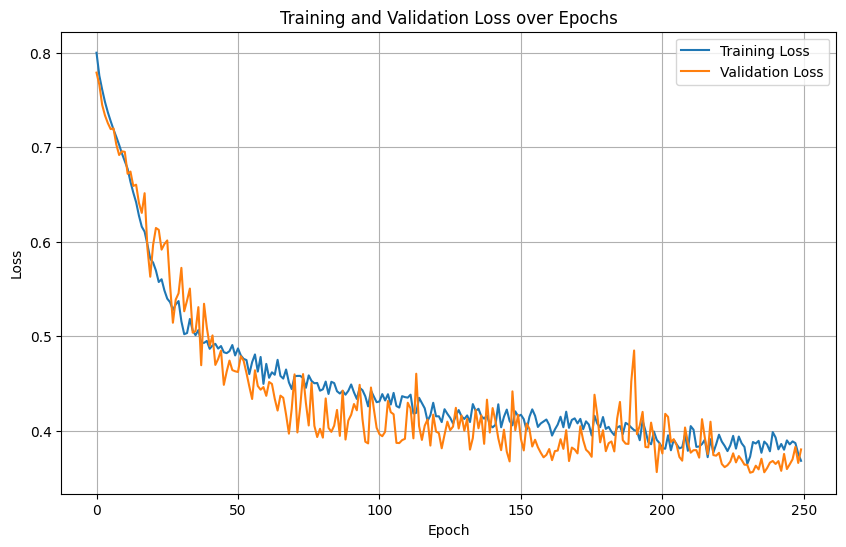

In [48]:
plt.figure(figsize=(10, 6))
plt.plot(range(0, len(train_losses)), train_losses, label='Training Loss')
plt.plot(range(0, len(val_losses)), val_losses, label='Validation Loss')
plt.title('Training and Validation Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

**Plot Dice Score over Epochs**

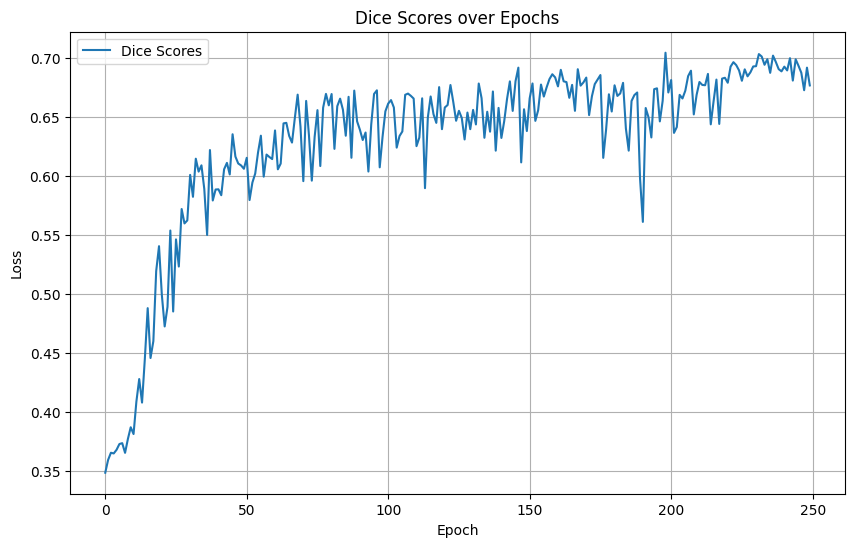

Highest Dice Score: 0.7043058276176453 at epoch 198


In [49]:
plt.figure(figsize=(10, 6))
plt.plot(range(0, len(dice_scores)), dice_scores, label='Dice Scores')
plt.title('Dice Scores over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Find the highest Dice score
highest_dice_score = max(dice_scores)
highest_epoch = dice_scores.index(highest_dice_score)

# Print the highest Dice score
print(f"Highest Dice Score: {highest_dice_score} at epoch {highest_epoch}")

**Plot Predicted Samples**

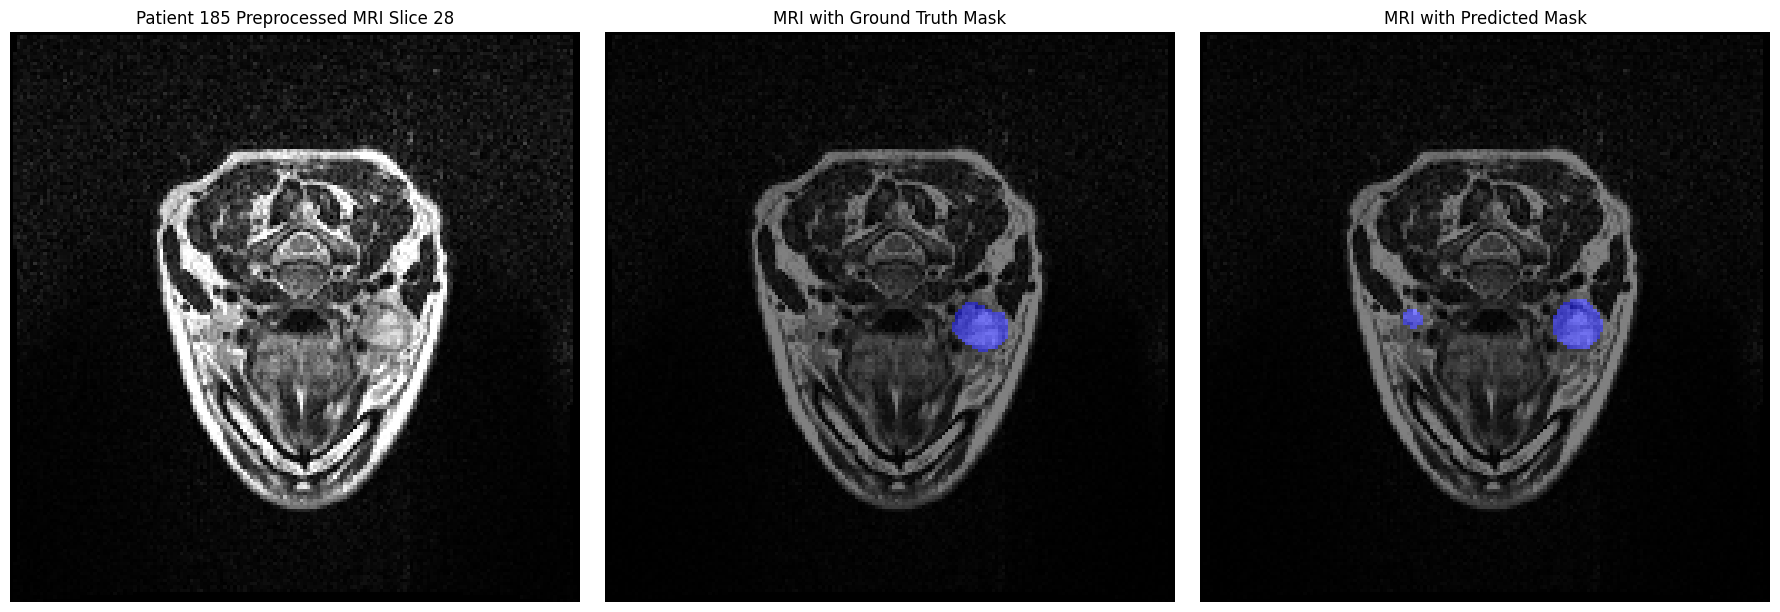

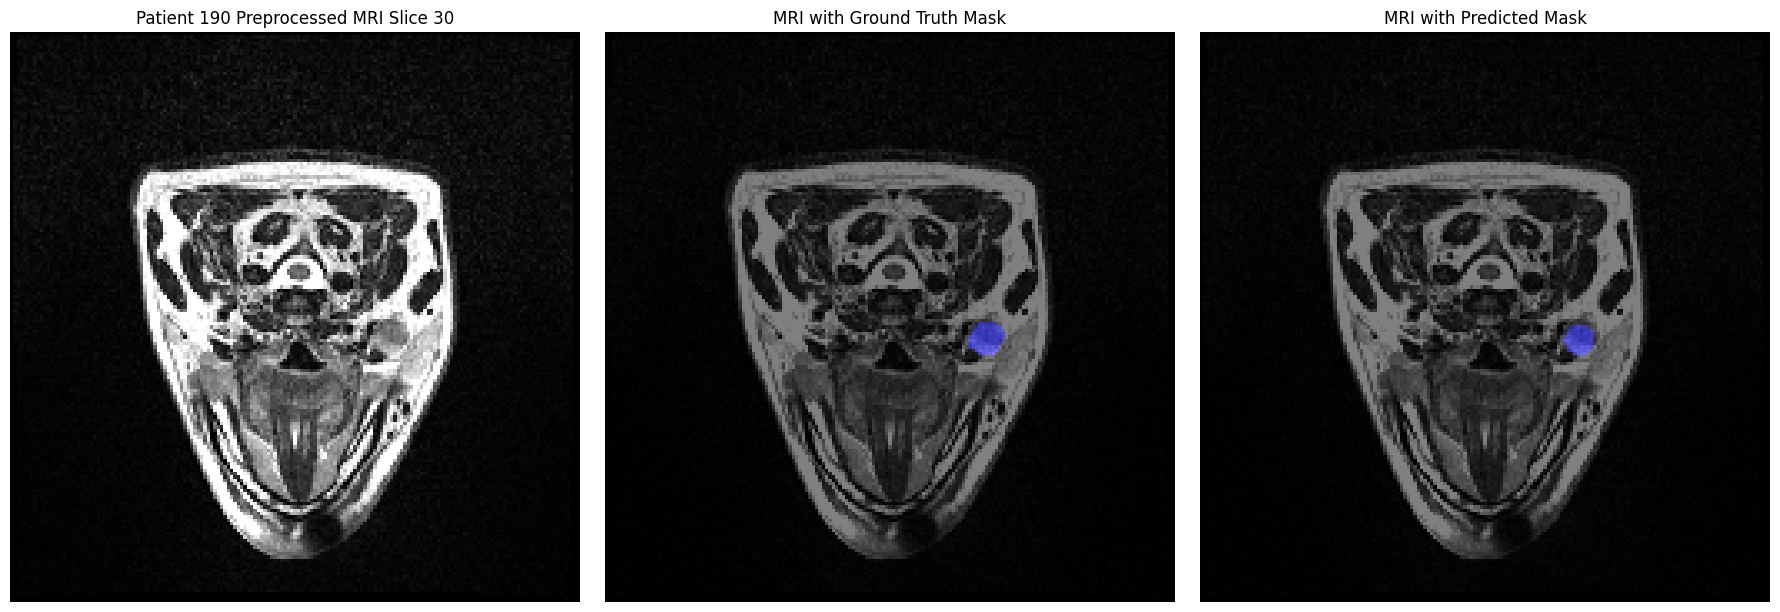

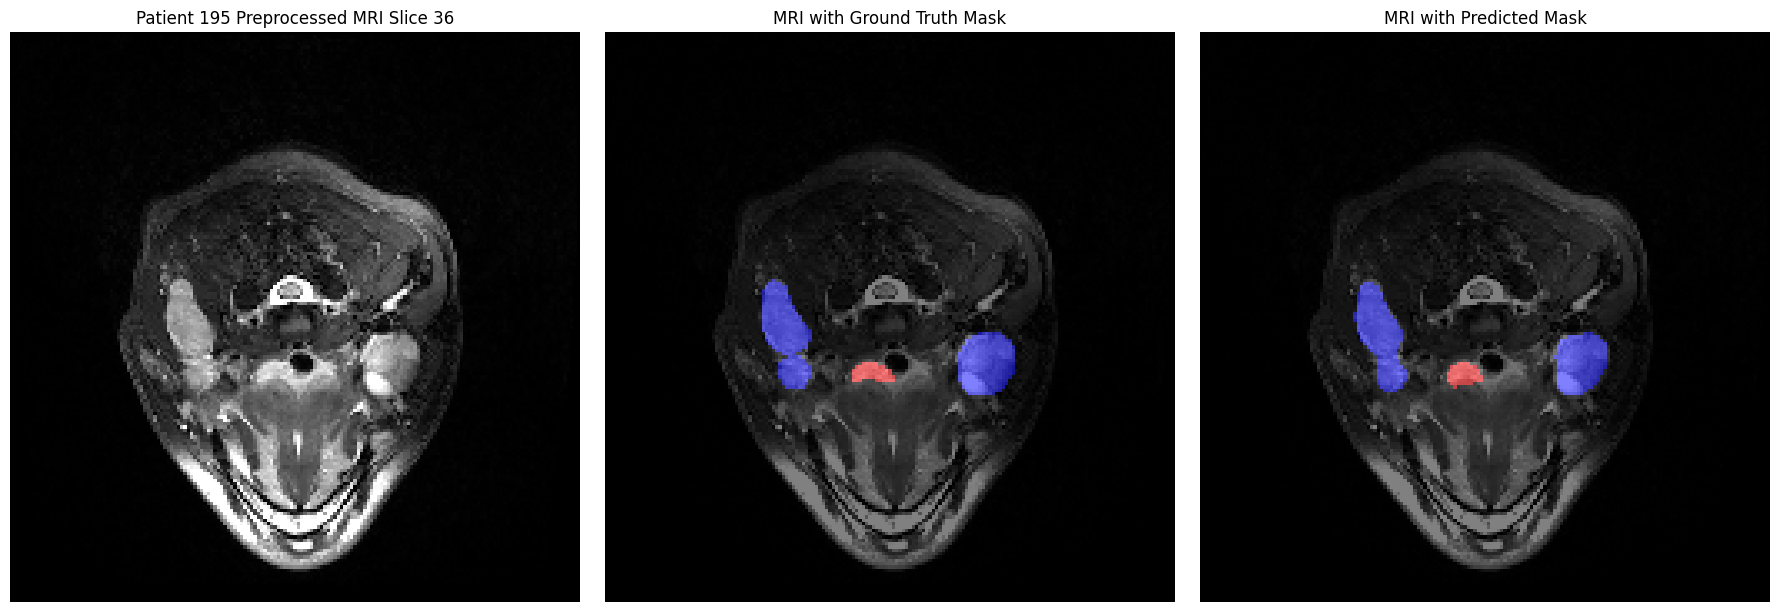

In [50]:
def plot_prediction(train_dir, val_transforms, model, patient_id, slice_index=None, device='cpu'):
    # Define paths
    mri_path = os.path.join(train_dir, patient_id, 'preRT', f'{patient_id}_preRT_T2.nii.gz')
    mask_path = os.path.join(train_dir, patient_id, 'preRT', f'{patient_id}_preRT_mask.nii.gz')
    
    # Preprocess the image and label
    processed = val_transforms({"image": mri_path, "label": mask_path})
    preprocessed_image_tensor = processed["image"]
    preprocessed_label_tensor = processed["label"]

    # Convert tensors to numpy arrays
    preprocessed_image_np = preprocessed_image_tensor.cpu().numpy()
    preprocessed_label_np = preprocessed_label_tensor.cpu().numpy()

    # Remove channel dimension if present
    if preprocessed_image_np.shape[0] == 1:
        preprocessed_image_np = np.squeeze(preprocessed_image_np, axis=0)

    if preprocessed_label_np.ndim == 4 and preprocessed_label_np.shape[0] == 1:
        preprocessed_label_np = np.squeeze(preprocessed_label_np, axis=0)

    # Select middle slice if not specified
    if slice_index is None:
        slice_index = preprocessed_image_np.shape[2] // 2

    # Extract slices and transpose
    mri_slice = preprocessed_image_np[:, :, slice_index].T
    mask_slice = preprocessed_label_np[:, :, slice_index].T

    # Run the model to get predictions
    model.eval()
    with torch.no_grad():
        input_tensor = preprocessed_image_tensor.unsqueeze(0).to(device)
        with torch.amp.autocast(str(device)):
            output = sliding_window_inference(input_tensor, (96, 96, 96), 4, model)
            probabilities = torch.softmax(output, dim=1)
            predicted = torch.argmax(probabilities, dim=1).squeeze(0).cpu().numpy()
    
    # Extract the predicted slice and transpose
    predicted_slice = predicted[:, :, slice_index].T
    
    # Define colormap for mask
    cmap = colors.ListedColormap(['black', 'red', 'blue'])
    norm = colors.BoundaryNorm([-0.5, 0.5, 1.5, 2.5], cmap.N)
    
    # Create subplots
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # 1. Preprocessed MRI Slice
    axes[0].imshow(mri_slice, cmap='gray', origin='upper')
    axes[0].set_title(f'Patient {patient_id} Preprocessed MRI Slice {slice_index}')
    axes[0].axis('off')

    # 2. MRI with Ground Truth Mask Overlay
    axes[1].imshow(mri_slice, cmap='gray', origin='upper')
    axes[1].imshow(mask_slice, cmap=cmap, norm=norm, alpha=0.5, origin='upper')
    axes[1].set_title('MRI with Ground Truth Mask')
    axes[1].axis('off')
    
    # 3. MRI with Predicted Mask Overlay
    axes[2].imshow(mri_slice, cmap='gray', origin='lower')
    axes[2].imshow(predicted_slice, cmap=cmap, norm=norm, alpha=0.5, origin='upper')
    axes[2].set_title('MRI with Predicted Mask')
    axes[2].axis('off')
    
    # Adjust layout
    plt.tight_layout()
    plt.show()
    
# Ensure the model is on the correct device
model.to(device)

# Plot samples from a few patients
patient_ids = ['185','190','195']
for pid in patient_ids:
    plot_prediction(TRAIN_DIR, val_transforms, model, patient_id=pid, device=device)